<a class="anchor" id="toc"></a>
# Filling galaxies space with identical GMCs

1. The case for a 3D radial profile in flux (*abandoned*)
    1. [Equations for radial profile](#equations)
    2. [Filling the mass profile with GMCs](#filling)
    3. [Linking X-ray flux and GMC radial distance](#linking)
    4. [CO SLED of a X-ray galaxy](#XCOSLED)
2. The case for a 2D radial profile in surface brightness
    1. [Equations for the surface brightness profile](#SBequations)
    2. [GMC distribution in each galaxy](#GMCdistr)
    3. [Generating PDR and XDR emission for each galaxy](#GMCpdrxdr)
    4. [PDR+XDR combined](#combined)
    5. [The G0 floor](#G0floor)
    6. [PROBLEM: missing CO(1-0) flux](#CO1)
    7. [PROBLEM: increase the mid-J flux](#midJ)
3. The diffuse molecular ISM
    1. [Spreading the ICM on the galaxy scale](#spreadICM)

In [3]:
from gmc_module import *



| Model | $M_{GMC} (M_{\odot})$ | $r_{GMC} (pc)$ | $\rho_0 (g/cm^{3})$   | $\mathcal{M}$ | $n_0 (cm^{-3})$ |
| ----- | :-------------------: | :------------: | :-------------------: | :-----------: | :------------:  |
| A     | $6.2 \times 10^3$     | $4$            | $8.2 \times 10^{-22}$ | $10$          | $401.8$         |
| B     | $9.9 \times 10^4$     | $16$           | $2.1 \times 10^{-22}$ | $20$          | $102.9$         |
| C     | $3.9 \times 10^6$     | $100$          | $3.3 \times 10^{-23}$ | $50$          | $16.2$          |
| V19   | $1.0 \times 10^5$     | $15$           | $6.1 \times 10^{-22}$ | $10$          | $300.0$         |



In [34]:
for gmc in gmclist:
    print(gmc.M / (pi * gmc.R**2))

123.34508089621889
123.0964012976378
124.14085561167836
141.4710605261292


# Useful equations

#### Conversion between luminosities from single dish radio/mm telescopes
$$\large
\frac{L}{L_{\odot}} = 3.195 \times 10^{-11} \left( \frac{\nu_e}{\mbox{GHz}} \right)^3 
\frac{L^{\prime}}{\mbox{K km/s pc}^2}
$$

***
***
# The case for a 3D radial profile in flux: equations for radial profile <a class="anchor" id="equations"></a>
([back to top](#toc))

$$\large
S_{CO} (<r^{\prime}) = 2 \pi \int_{-r^{\prime}}^{r^{\prime}} \int_0^{r^{\prime}} r \, S_{CO}(r,z) \, dr \, dz
$$

$$\large
L_{CO} = \frac{0.118 \, D^2_L}{1+z} S_{CO}
$$

$$\large
M_{mol} (<r) = 8.9 \times 10^4 \, \frac{X_{CO}}{2 \times 10^{20}} \, L_{CO} (<r) = 
8.9 \times 10^4 \, \frac{X_{CO}}{2 \times 10^{20}} \, L_{CO,tot}
\, (1 - e^{-r/z_{CO}}) \, [1 - e^{-r/r_{CO}} (r/r_{CO} + 1)]
$$

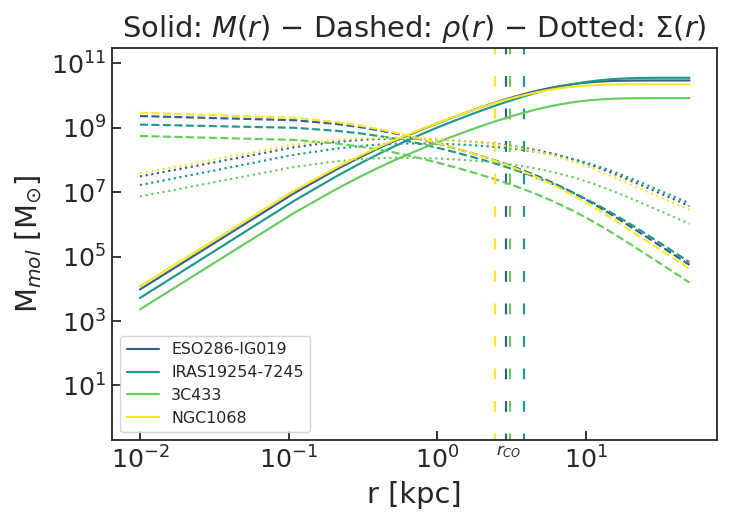

In [87]:
# new dataframe with corrected equations (select non-NaN CO1 only)
df = pd.read_csv('../AGN_impact_CO_sample/datasets/cat_2022c.csv', index_col='Name')
df = df.loc[df['CO1'].dropna().index]

Xco=2
radii = np.arange(0.01,50.1,0.1)
glist = df.sort_values(by='fcorr', ascending=False).index[-4:]
colorlist = cm.viridis(np.linspace(0.3, 1, len(glist)))
for g, c in zip(glist, colorlist):
    rCO, zCO = df.loc[g, 'rCO'], df.loc[g, 'rCO'] * 0.01/0.17
    zfac = 1 - np.exp(-radii / (zCO))
    rfac = 1 - np.exp(-radii / rCO) * (radii/rCO + 1)
    Mmol = 8.9e4 * (Xco/2) * df.loc[g, 'CO1tot'] * zfac * rfac
    plt.loglog(radii, Mmol, label=g, color=c)
    plt.loglog(radii, Mmol/((4/3.)*np.pi*radii**3), ls='dashed', color=c)
    plt.loglog(radii, Mmol/(np.pi*radii**2), ls='dotted', color=c)
    SCO0 = df.loc[g, 'CO1tot'] / (4*np.pi*(rCO**2)*zCO)
    SCOr = SCO0 * np.exp(-radii/rCO)# * np.exp(-radii/zCO)
    #plt.loglog(radii, SCOr, ls='dashdot', color=c)
    plt.axvline(rCO, color=c, ls=(2, (5, 10)))
plt.text(s=r'$r_{CO}$', x=2.5, y=.7e-1, size=9)
plt.legend()
plt.title(r'Solid: $M(r)$ $-$ Dashed: $\rho(r)$ $-$ Dotted: $\Sigma(r)$')
plt.xlabel('r [kpc]')
plt.ylabel(r'M$_{mol}$ [M$_{\odot}$]')
plt.ylim([2e-1, 3e11]);

# Filling the mass profile with GMCs <a class="anchor" id="filling"></a>
([back to top](#toc))

We fill the mass radial profiles with multiple fiducial GMCs from Vallini+2019:

```python
Mgmc = 1e5  # Msun
Rgmc = 15   # pc
n0 = 300    # cm^-3
Mach = 10
Tgmc = 20   # K
```

In [17]:
# GMC properties
Mgmc = 1e5  # Msun
Rgmc = 15   # pc
n0 = 300    # cm^-3
Mach = 10
Tgmc = 20   # K

At which radii the mass profile contains 1, 2, $n$ GMCs?

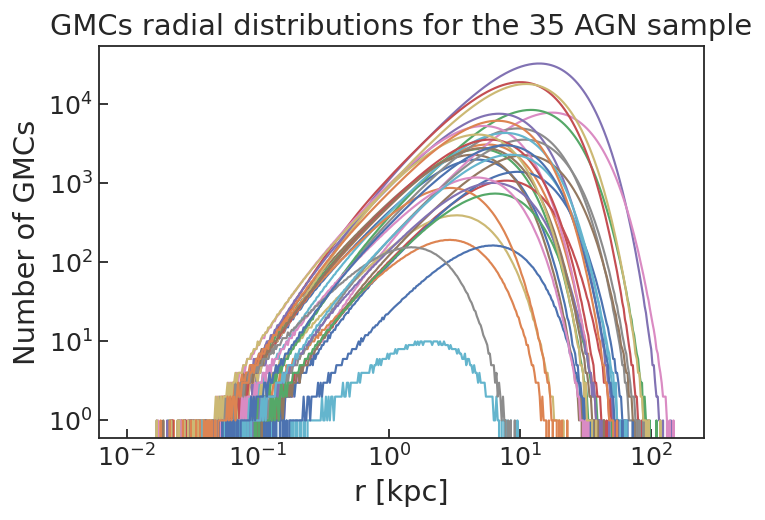

In [19]:
df = pd.read_csv('../AGN_impact_CO_sample/datasets/cat_2022c.csv', index_col='Name')
Xco = 2 # 1e20 cm-2/(K.km/s)
for g in df.index:
    r = 10**np.arange(-2,2.2,0.01) # kpc
    zfac = 1 - np.exp(-r / (df.loc[g, 'rCO'] * 0.01/0.17))
    rfac = 1 - np.exp(-r / df.loc[g, 'rCO']) * (r/df.loc[g, 'rCO'] + 1)
    Mmol = 8.9e4 * (Xco/2) * df.loc[g, 'CO1tot'] * zfac * rfac
    Ngmc = (Mmol / Mgmc).astype('int') # truncated integer
    plt.plot(r, np.diff(Ngmc, prepend=0))
plt.xlabel('r [kpc]')
plt.ylabel('Number of GMCs')
plt.title('GMCs radial distributions for the 35 AGN sample')
plt.yscale('log')
plt.xscale('log');

# Linking X-ray flux and GMC radial distance <a class="anchor" id="linking"></a>
([back to top](#toc))

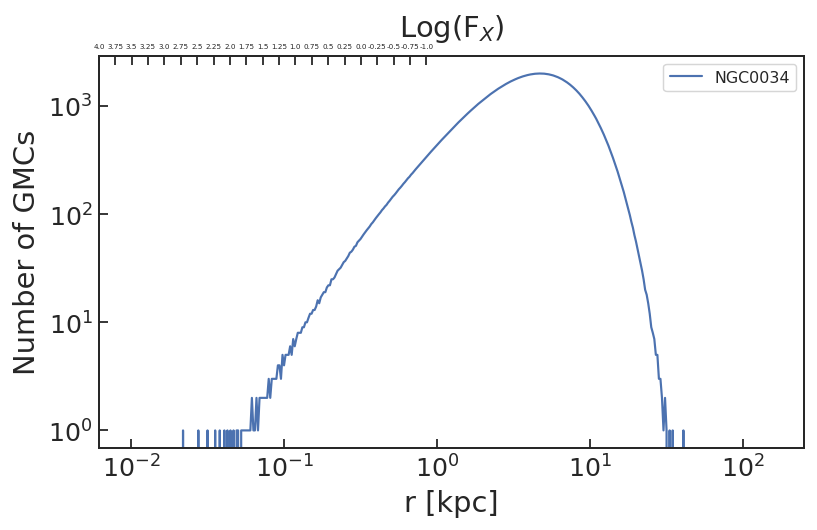

In [24]:
g = 'NGC0034'
Xco = 2 # 1e20 cm-2/(K.km/s)
r = 10**np.arange(-2,2.2,0.01) # kpc
zfac = 1 - np.exp(-r / (df.loc[g, 'rCO'] * 0.01/0.17))
rfac = 1 - np.exp(-r / df.loc[g, 'rCO']) * (r/df.loc[g, 'rCO'] + 1)
Mmol = 8.9e4 * (Xco/2) * df.loc[g, 'CO1tot'] * zfac * rfac
Ngmc = (Mmol / Mgmc).astype('int') # truncated integer

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(r, np.diff(Ngmc, prepend=0), label=g)
ax1.set_xlabel('r [kpc]')
ax1.legend()
ax1.set_ylabel('Number of GMCs')
ax1.set_yscale('log')
ax1.set_xscale('log')

# top X-axis with logFX corresponding to radii
logFX = np.arange(-1, 4.2, 0.25) # from the Cloudy grid
logLX = df.loc[g, 'logLX']
logRXticks = 0.5 * (logLX - logFX - np.log10(4*np.pi)) - np.log10(1e3*pc)
ax2 = ax1.twiny()
ax2.set_xlabel(r'Log(F$_X$)')
ax2.set_xlim(ax1.get_xlim())
ax2.set_xscale('log')
ax2.set_xticks(10**logRXticks)
ax2.set_xticklabels(logFX);
ax2.tick_params(axis='both', which='major', labelsize=4)

We can calculate, around the simulated $F_X$ values, the corresponding radius and number of GMCs. Since the simulated $F_X$ values are separated by 0.25 dex, the radii will be separated by 0.125 dex. So, between two adjacent $F_X$ values $(F_{X,i}, F_{X,j})$, the median radial point will be $log(r_i) + 0.125/2 = log(r_j) - 0.125/2$, where $r_i = \sqrt{L_X / (4 \pi F_{X,i})}$ and $r_j = \sqrt{L_X / (4 \pi F_{X,j})}$.

We want to find, for every galaxy, the number of GMCs affected by a certain simulated $F_X$, e.g. around $log(F_X) = 2$. Knowing $log(L_X)$, the corresponding radius for this flux is $log(r) = 0.5 \, [log(L_X) - log(F_X) - log(4 \pi)]$.

In [27]:
df = pd.read_csv('../AGN_impact_CO_sample/datasets/cat_2022c.csv', index_col='Name')
df = df.loc[df['CO1tot'].dropna().index]
Xco = 2
Mgmc = 6.2e3
logFX = np.arange(-1, 4.2, 0.25)[::-1] # from the Cloudy grid [log(erg/s/cm2)]

# filling the dataframe for the number of XDR-GMCs at given FX
Nxdr = pd.DataFrame(index=df.index,
                    columns=['x' + ('%.2f' % x).replace('.', '') for x in logFX] + ['rmndr'])
for g in df.index:
    logLX = df.loc[g, 'logLX'] # log(erg/s)
    logRXticks = 0.5 * (logLX - logFX - np.log10(4*np.pi)) - np.log10(1e3*pc) # log(kpc)
    for logr, F in zip(logRXticks, logFX):
        r = np.array([10**(logr-0.125/2), 10**(logr+0.125/2)])
        zfac = 1 - np.exp(-r / (df.loc[g, 'rCO'] * 0.01/0.17))
        rfac = 1 - np.exp(-r / df.loc[g, 'rCO']) * (r/df.loc[g, 'rCO'] + 1)
        Mmol = 8.9e4 * (Xco/2) * df.loc[g, 'CO1tot'] * rfac * zfac
        Ngmc = (Mmol / Mgmc).astype('int') # truncated integer
        Nxdr.loc[g, 'x' + ('%.2f' % F).replace('.', '')] = Ngmc[1] - Ngmc[0]
    Mmol_tot = 8.9e4 * (Xco/2) * df.loc[g, 'CO1tot']
    Nxdr.loc[g, 'rmndr'] = int(Mmol_tot / Mgmc) - Ngmc[1]

In [28]:
Nxdr.to_csv('Nxdr_62e3Msun_Xco2.csv')

# CO SLED of a X-ray galaxy <a class="anchor" id="XCOSLED"></a>
([back to top](#toc))

In [24]:
df = pd.read_csv('../AGN_impact_CO_sample/datasets/cat_2022c.csv', index_col='Name')
Nxdr = pd.read_csv('./extractions/Nxdr_1e5Msun_Xco2.csv', index_col='Name')
for f in sorted(os.listdir('./extractions/')): print(f)
ndf_name = 'GMC_n300_R15pc_M10_20K'
wd = './extractions/' + ndf_name + '/'
ndf = pd.read_csv('./extractions/' + ndf_name + '.csv')
pdr_df, xdr_df = [], []
for f in sorted(os.listdir(wd)):
    this_extra = pd.read_csv(wd + f, index_col=0)
    logR_cm = ndf.loc[int(f[-6:-4]), 'logR'] + np.log10(pc)
    if 'PDR' in f: pdr_df.append(this_extra * 2*np.pi*(10**logR_cm)**2 / lsun)
    if 'XDR' in f: xdr_df.append(this_extra * 2*np.pi*(10**logR_cm)**2 / lsun)

pdr_gmc = sum(pdr_df)
xdr_gmc = sum(xdr_df)

GMC_n102_R16pc_M10
GMC_n102_R16pc_M20
GMC_n102_R16pc_M20.csv
GMC_n16_R100pc_M50
GMC_n16_R100pc_M50.csv
GMC_n300_R15pc_M10_20K
GMC_n300_R15pc_M10_20K.csv
GMC_n401_R4pc_M10
GMC_n401_R4pc_M10.csv
Nxdr_1e5Msun_Xco2.csv
Nxdr_39e6Msun_Xco2.csv
Nxdr_62e3Msun_Xco2.csv
Nxdr_99e4Msun_Xco2.csv


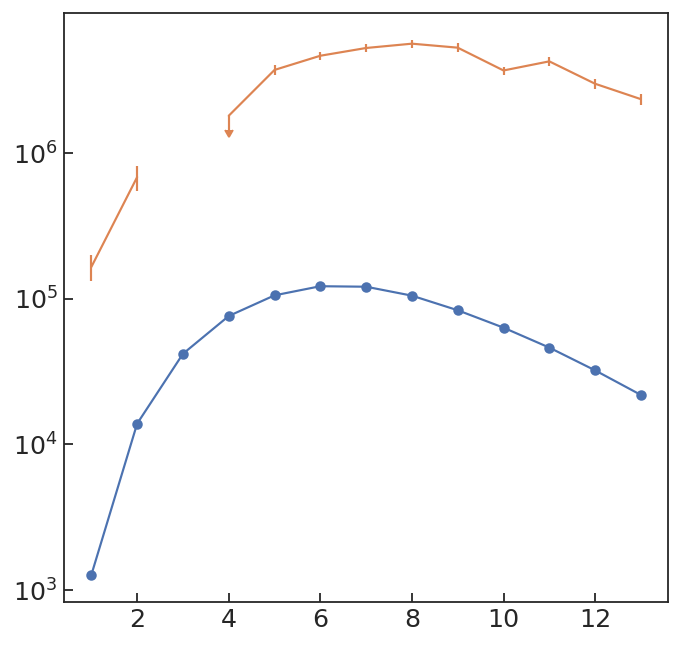

In [26]:
colist = ['CO' + str(x) for x in np.arange(1,14)]
lo = [co + '_lo' for co in colist]
hi = [co + '_up' for co in colist]
ulim = [co + '_ulim' for co in colist]

plt.figure(figsize=(6,6))
for g in df.index[:1]:
    mysled = (Nxdr.loc[g, xdr_gmc.index] * xdr_gmc.T).T.sum()

    plt.plot(np.arange(1,14), mysled[:13], 'o-', label=g+' Simulated')
    plt.errorbar(np.arange(1,14), df.loc[g, colist], 
                 yerr = [df.loc[g, lo], df.loc[g, hi]],
                 uplims = df.loc[g, ulim], label=g+' Observed')
#plt.title(g)
plt.yscale('log')
#plt.legend();

***
***
# The case for a 2D radial profile in surface brightness: the equations <a class="anchor" id="SBequations"></a>
([back to top](#toc))

We assume the mass surface density to follow an exponential profile

$$\large
\Sigma(r) = \Sigma(0) \, e^{-r/r_{CO}} \; \; \; [M_{\odot} \, \text{pc}^{-2}]
$$

Following this profile, the mass within a certain radius $r^{\prime}$ will be:

$$\large
M(r \leq r^{\prime}) = 2 \pi \, \Sigma(0) \int_0^{r^{\prime}} r \, e^{-r/r_{CO}} \, dr = 
2 \pi \, \Sigma(0) \, r_{CO}^2 \, \left[ 1 - e^{-r^{\prime}/r_{CO}} (r^{\prime}/r_{CO}+1) \right] \\
$$

If we integrate up to $r \rightarrow +\infty$, the result will be the total molecular mass.
We initially obtain $M_{tot}$ from the CO(1-0) luminosity $L_{CO,tot}$:

$$\large M_{tot} = 2 \pi \, \Sigma(0) \, r_{CO}^2 = 
8.9 \times 10^4 \, \frac{X_{CO}}{2 \times 10^{20}} \, L_{CO,tot}
$$

This $L_{CO,tot}$ also comes from an exponential profile, 
with the same scale length $r_{CO} = 0.17 \, r_{25}$, 
but in 3D, so that it has also a scale height $z_{CO} = 0.01 \, r_{25}$.
We can compute $L_{CO,tot}$ from the observed $L_{CO}(r_{\theta})$,
where $r_{\theta}$ is half of the FWHM of the single-dish radio telescope in linear physical units (e.g. kpc):

$$\large
L_{CO,tot} = 4 \pi \, L_{CO}(0) \, r_{CO}^2 \, z_{CO} = 
\frac{L_{CO}(r_{\theta})}{(1-e^{-r_{\theta}/z_{CO}}) \, [1-e^{-r_{\theta}/r_{CO}} (r_{\theta}/r_{CO} + 1]}
$$

Putting it all together:

$$\large
\Longrightarrow M(r \leq r^{\prime}) = \frac{8.9 \times 10^4 \, X_{CO} \, L_{CO}(r_{\theta}) \,
[1 - e^{-r^{\prime}/r_{CO}} (r^{\prime}/r_{CO}+1)]}{
(1-e^{-r_{\theta}/z_{CO}}) \, [1-e^{-r_{\theta}/r_{CO}} (r_{\theta}/r_{CO} + 1]} \; \; \; [M_{\odot}]
$$


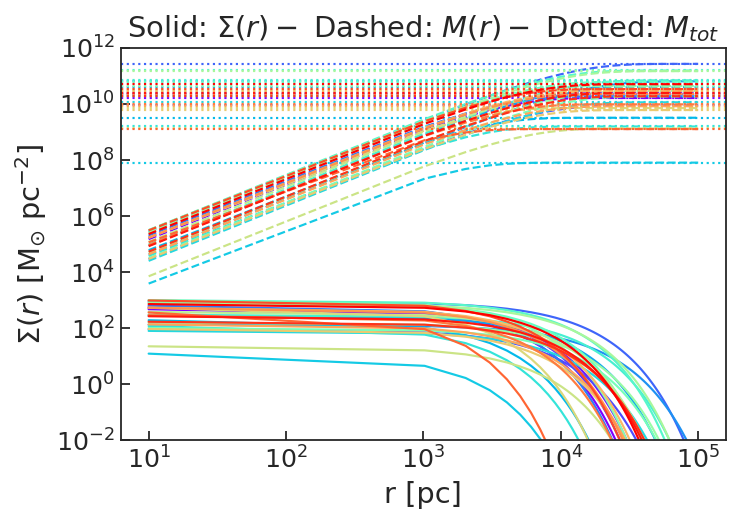

In [308]:
df = pd.read_csv('../AGN_impact_CO_sample/datasets/cat_2022c.csv', index_col='Name')
glist = df['CO1'].dropna().index
Xco = 2
Mtot = 8.9e4 * (Xco/2) * df.loc[glist, 'CO1tot']
Sigma0 = Mtot/(2*np.pi*(df.loc[glist, 'rCO']*1e3)**2)

radii = np.linspace(1e1, 1e5, 100)
for g, c in zip(glist, cm.rainbow(np.linspace(0, 1, len(glist)))):
    rCO = df.loc[g, 'rCO'] * 1e3 # pc
    SigmaR = Sigma0.loc[g] * np.exp(-radii/rCO)
    MassR = 2*np.pi*Sigma0.loc[g]*rCO**2 * (1-np.exp(-radii/rCO)*(radii/rCO + 1))
    plt.plot(radii, SigmaR, ls='solid', color=c)
    plt.plot(radii, MassR, ls='dashed', color=c)
    plt.axhline(Mtot.loc[g], ls='dotted', color=c)
plt.xlabel('r [pc]')
plt.ylabel(r'$\Sigma(r)$ [M$_{\odot}$ pc$^{-2}$]')
plt.title(r'Solid: $\Sigma(r) -$ Dashed: $M(r) -$ Dotted: $M_{tot}$')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-2, 1e12]);

# GMC distribution in each galaxy <a class="anchor" id="GMCdistr"></a>
([back to top](#toc))

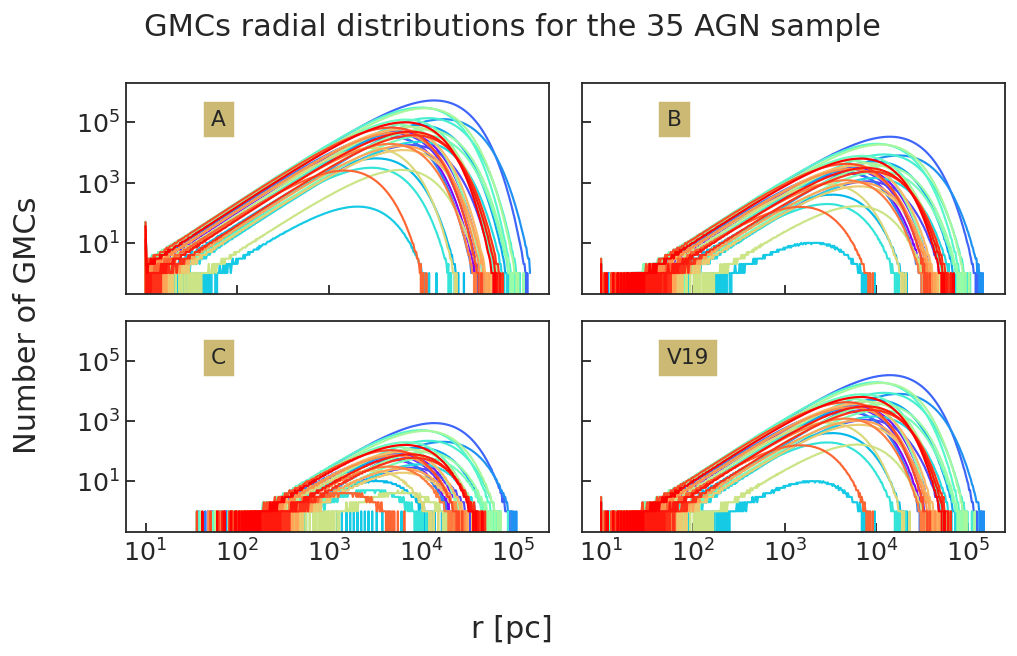

In [27]:
Xco = 2 # 1e20 cm-2/(K.km/s)
r = 10**np.arange(-2,2.2,0.01) # kpc
df = pd.read_csv('../AGN_impact_CO_sample/datasets/cat_2022c.csv', index_col='Name')
glist = df['CO1'].dropna().index

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, figsize=(8,5), sharey=True, sharex=True)

for gmc, ax in zip(gmclist, [ax1, ax2, ax3, ax4]):
    Mgmc = gmc.M
    for g, c in zip(glist, cm.rainbow(np.linspace(0,1,len(glist)))):
        rCO = df.loc[g, 'rCO'] # kpc
        Mtot = 8.9e4 * (Xco/2) * df.loc[g, 'CO1tot'] # Msun
        rfac = 1 - (np.exp(-r/rCO) * (r/rCO + 1))
        Mmol = Mtot * rfac
        Ngmc = (Mmol / Mgmc).astype('int') # truncated integer
        SigmaNum = Ngmc * Mgmc / (np.pi * (r*1e3)**2)
        Sigma0 = Mtot/(2*np.pi*(rCO*1e3)**2)
        SigmaR = Sigma0 * np.exp(-r/rCO)
        ax.plot(r*1e3, np.diff(Ngmc, prepend=0), color=c)
        #ax.plot(r*1e3, SigmaNum/SigmaR, ls='dotted', color=c) # check ratio between Sigmas
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.text(x=0.2, y=0.8, s=gmc.name, transform=ax.transAxes, size=12, backgroundcolor='y')
    ax.set_ylim([2e-1, 2e6])
    ax.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
fig.supxlabel('r [pc]')
fig.supylabel('Number of GMCs')
fig.suptitle('GMCs radial distributions for the 35 AGN sample')
plt.tight_layout();

This is the mass distribution of the GMCs. Let's also check their volumes. Every GMC has a mass $M_{GMC} = 10^5$ M$_{\odot}$ and a radius $R_{GMC} = 15$ pc. If we assume a disk galaxy where the molecular gas follows an exponential profile in $r$ and $z$ with scale lengths respectively $r_{CO} = 0.17 \, r_{25}$ and $z_{CO} = 0.01 \, r_{25}$, the volume can be approximated to the volume of a cylinder of radius $r_{CO}$ and height $2 \, z_{CO}$: $V_{mol}(r) = 2 \pi z_{CO} r^2$

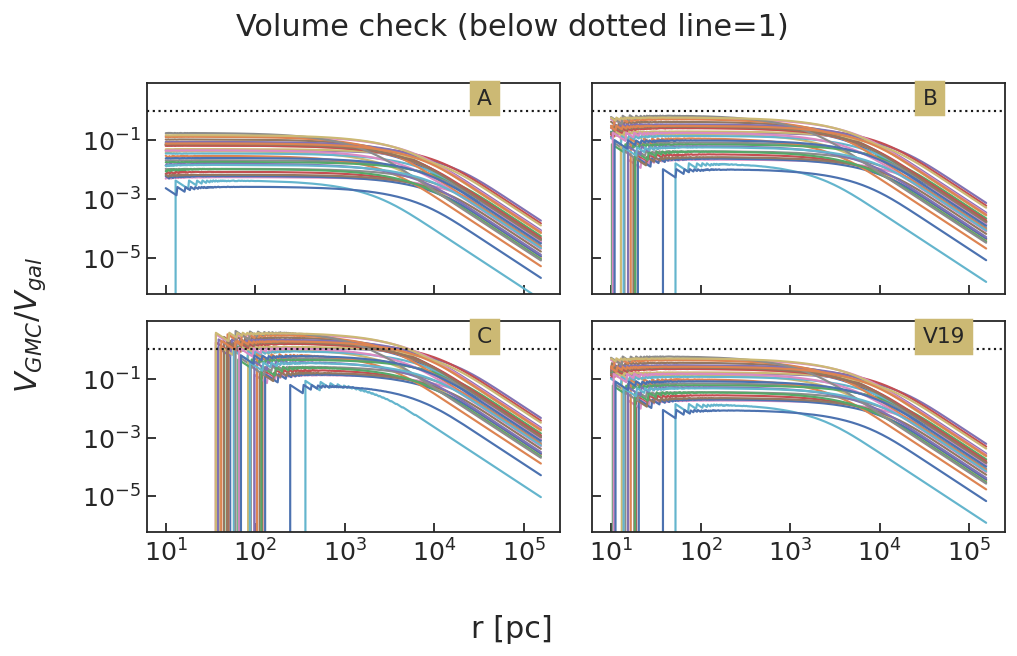

In [310]:
Xco = 2 # 1e20 cm-2/(K.km/s)
r = 10**np.arange(-2,2.2,0.01) # kpc
df = pd.read_csv('../AGN_impact_CO_sample/datasets/cat_2022c.csv', index_col='Name')
glist = df['CO1'].dropna().index

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, figsize=(8,5), sharey=True, sharex=True)

for gmc, ax in zip(gmclist, [ax1, ax2, ax3, ax4]):
    Mgmc = gmc.M
    Rgmc = gmc.R
    for g in glist:
        rCO = df.loc[g, 'rCO'] # kpc
        zCO = rCO * 1e3 * 0.01/0.17 # pc
        Vgal = 2 * np.pi * zCO * (r*1e3)**2 # pc^3
        Mtot = 8.9e4 * (Xco/2) * df.loc[g, 'CO1tot'] # Msun
        Mmol = Mtot * (1 - (np.exp(-r/rCO) * (r/rCO + 1)))
        Ngmc = (Mmol / Mgmc).astype('int') # truncated integer
        Vgmc = Ngmc * (4/3) * np.pi * Rgmc**3 # pc^3
        ax.plot(r*1e3, Vgmc/Vgal)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.axhline(1, color='k', ls='dotted')
    ax.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
    ax.text(x=0.8, y=0.9, s=gmc.name, transform=ax.transAxes, size=12, backgroundcolor='y')
fig.suptitle('Volume check (below dotted line=1)')
fig.supxlabel('r [pc]')
fig.supylabel(r'$V_{GMC} / V_{gal}$')
fig.tight_layout();

# Generating PDR and XDR emission for each galaxy <a class="anchor" id="GMCpdrxdr"></a>
([back to top](#toc))

Remember that $L_X(1-100 \mbox{ keV}) = L_X(2-10 \mbox{ keV}) \; / \; 0.256$

In [2]:
from gmc_module import *

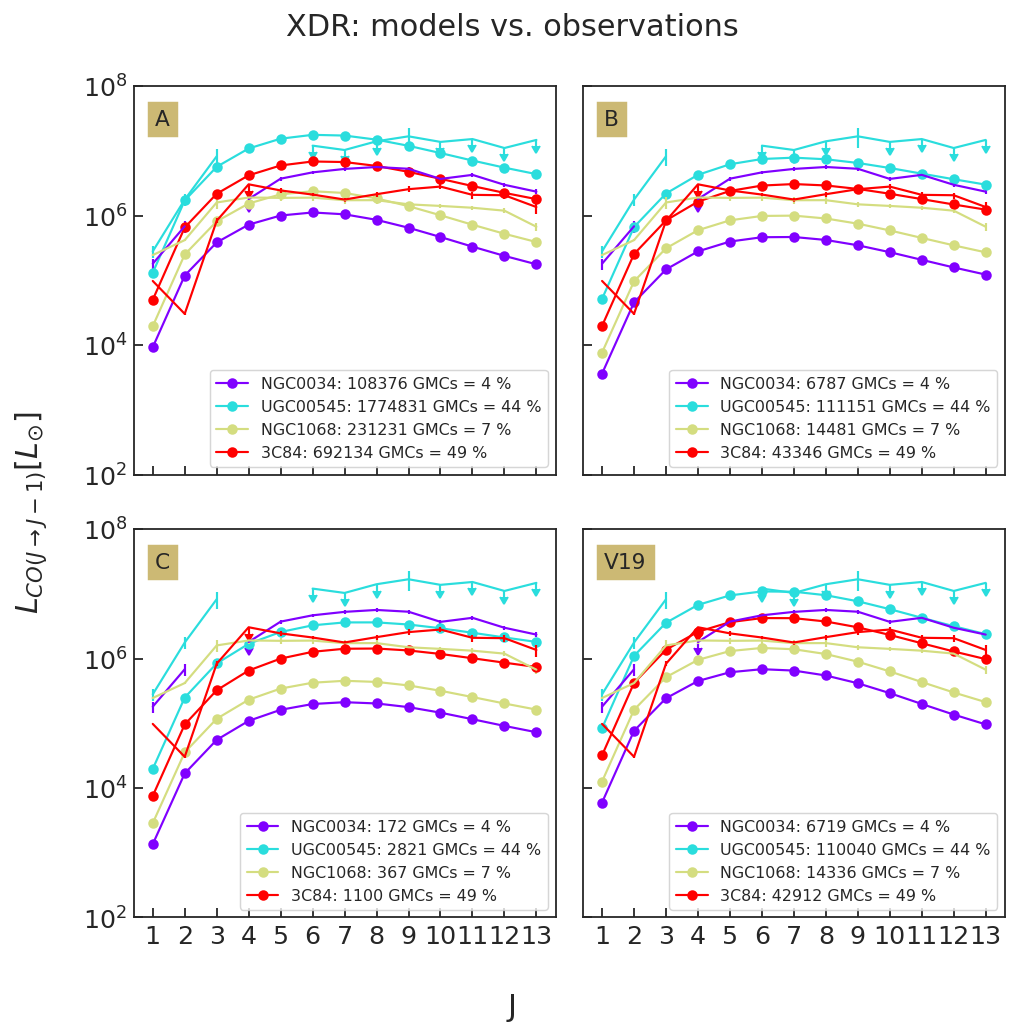

In [6]:
glist = [x for x in df['CO1'].dropna().index if x in frozenset(sers.index)]
colist, lo, hi, ulim = [['CO1tot' + suf] + ['CO' + str(x) + suf for x in np.arange(2,14)] 
                        for suf in ['', '_lo', '_up', '_ulim']]

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharey=True, sharex=True)

for gmc, ax in zip(gmclist, [ax1, ax2, ax3, ax4]):
    pdr_gmc, xdr_gmc = gmc.pdr_xdr()
    for g, c in zip(df.index[:4], cm.rainbow(np.linspace(0, 1, 4))):
        Mmol_tot, rCO, logLX = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'logLX']]
        Nxdr = gmc.galaxy_xdr(logLX - np.log10(0.256), rCO, Mmol_tot)
        mysled = (Nxdr.loc[xdr_gmc.index] * xdr_gmc.T).T.sum()
        lab = g + ': %.0f' % (Nxdr[:-1].sum()) + ' GMCs = %.0f' % (100*Nxdr[:-1].sum()/Nxdr.sum()) + ' %'
        ax.plot(np.arange(1,14), mysled[:13], 'o-', color=c, label=lab)
        ax.errorbar(np.arange(1,14), df.loc[g, colist], color=c,
                     yerr = [df.loc[g, lo], df.loc[g, hi]], uplims = df.loc[g, ulim])
    ax.set_yscale('log')
    ax.set_xticks(np.arange(1,14))
    ax.text(x=0.05, y=0.9, s=gmc.name, transform=ax.transAxes, size=12, backgroundcolor='y')
    ax.legend(loc='lower right')
    ax.set_ylim([1e2, 1e8])
fig.suptitle('XDR: models vs. observations')
fig.supxlabel('J')
fig.supylabel(r'$L_{CO(J \rightarrow J-1)} [L_{\odot}]$')
fig.tight_layout();

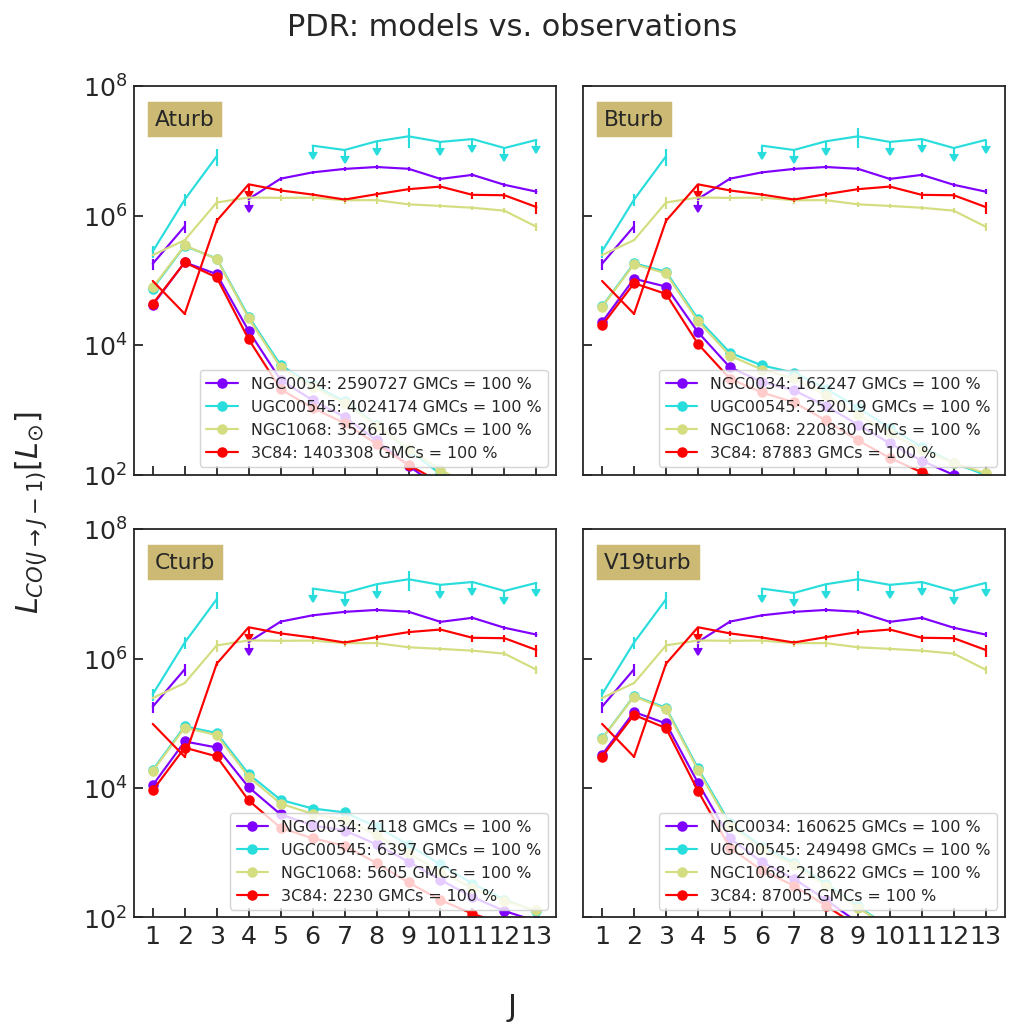

In [8]:
colist, lo, hi, ulim = [['CO1tot' + suf] + ['CO' + str(x) + suf for x in np.arange(2,14)] 
                        for suf in ['', '_lo', '_up', '_ulim']]
df = pd.read_csv('../AGN_impact_CO_sample/datasets/cat_2022c.csv', index_col='Name')
sers = pd.read_csv('/media/phd/catalogo/sersic_fit.csv', index_col='Name').drop(['Circinus', 'NGC4945'])
glist = [x for x in df['CO1'].dropna().index if x in frozenset(sers.index)]

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharey=True, sharex=True)

for gmc, ax in zip(gmcturb, [ax1, ax2, ax3, ax4]):
    pdr_gmc, xdr_gmc = gmc.pdr_xdr()
    for g, c in zip(df.index[:4], cm.rainbow(np.linspace(0, 1, 4))):
        Mmol_tot, rCO, SFR = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR']]
        Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
        Npdr = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=True)
        mysled = (Npdr.loc[pdr_gmc.index] * pdr_gmc.T).T.sum()
        lab = g + ': %.0f' % (Npdr[:-1].sum()) + ' GMCs = %.0f' % (100*Npdr[:-1].sum()/Npdr.sum()) + ' %'
        ax.plot(np.arange(1,14), mysled[:13], 'o-', color=c, label=lab)
        ax.errorbar(np.arange(1,14), df.loc[g, colist], color=c,
                     yerr = [df.loc[g, lo], df.loc[g, hi]], uplims = df.loc[g, ulim])
    ax.set_yscale('log')
    ax.set_xticks(np.arange(1,14))
    ax.text(x=0.05, y=0.9, s=gmc.name, transform=ax.transAxes, size=12, backgroundcolor='y')
    ax.legend(loc='lower right')
    ax.set_ylim([1e2, 1e8])
fig.suptitle('PDR: models vs. observations')
fig.supxlabel('J')
fig.supylabel(r'$L_{CO(J \rightarrow J-1)} [L_{\odot}]$')
fig.tight_layout();

## Check the number of GMCs in PDR/XDR cases

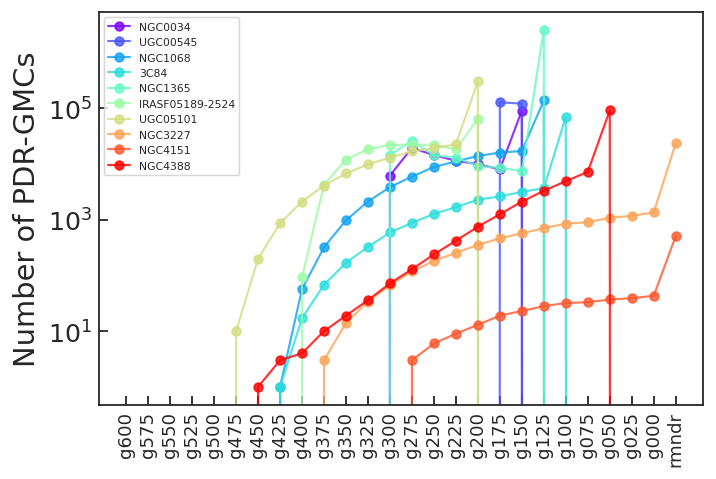

In [25]:
gmc = gmcV19
glist = [x for x in df['CO1'].dropna().index if x in frozenset(sers.index)][:10]
for g, c in zip(glist, cm.rainbow(np.linspace(0, 1, len(glist)))):
    Mmol_tot, rCO, SFR = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR']]
    Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
    Npdr = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR)
    plt.plot(Npdr.index, Npdr, 'o-', alpha=.8, label=g, color=c)
plt.legend(fontsize=6)
plt.ylabel('Number of PDR-GMCs')
plt.yscale('log')
plt.xticks(rotation=90, size=10);

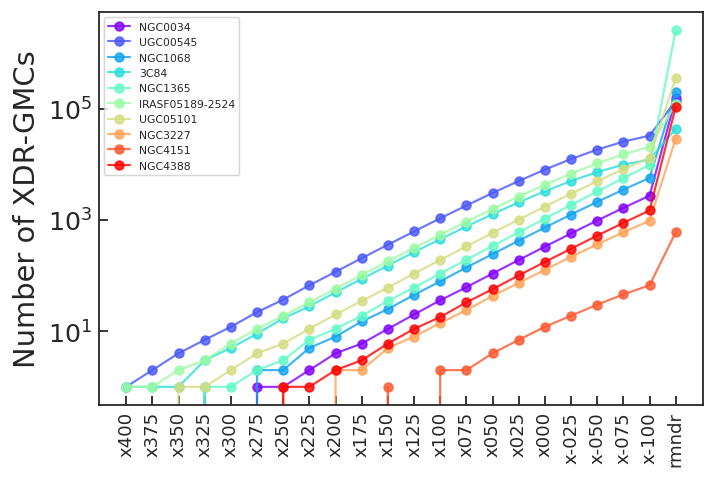

In [30]:
gmc = gmcV19
glist = [x for x in df['CO1'].dropna().index if x in frozenset(sers.index)][:10]
for g, c in zip(glist, cm.rainbow(np.linspace(0, 1, len(glist)))):
    Mmol_tot, rCO, logLX = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'logLX']]
    logLX_1_100 = logLX - np.log10(0.256)
    Nxdr = gmc.galaxy_xdr(logLX_1_100, rCO, Mmol_tot)
    plt.plot(Nxdr.index, Nxdr, 'o-', alpha=.8, label=g, color=c)
plt.legend(fontsize=6)
plt.ylabel('Number of XDR-GMCs')
plt.yscale('log')
plt.xticks(rotation=90, size=10);

# PDR+XDR combined <a class="anchor" id="combined"></a>
([back to top](#toc))

potresti fare anche un plot che sia la somma di PDR+XDR (cioe dei grafici che hai mandato adesso)? In sostanza la cosa interessante da vedere sarebbe un grafico in cui plotti CO SLED_ XDR (tratteggiato) CO SLED_PDR (dotted) e somma dei due (solid). Ovviamente riportando anche il dato osservativo.

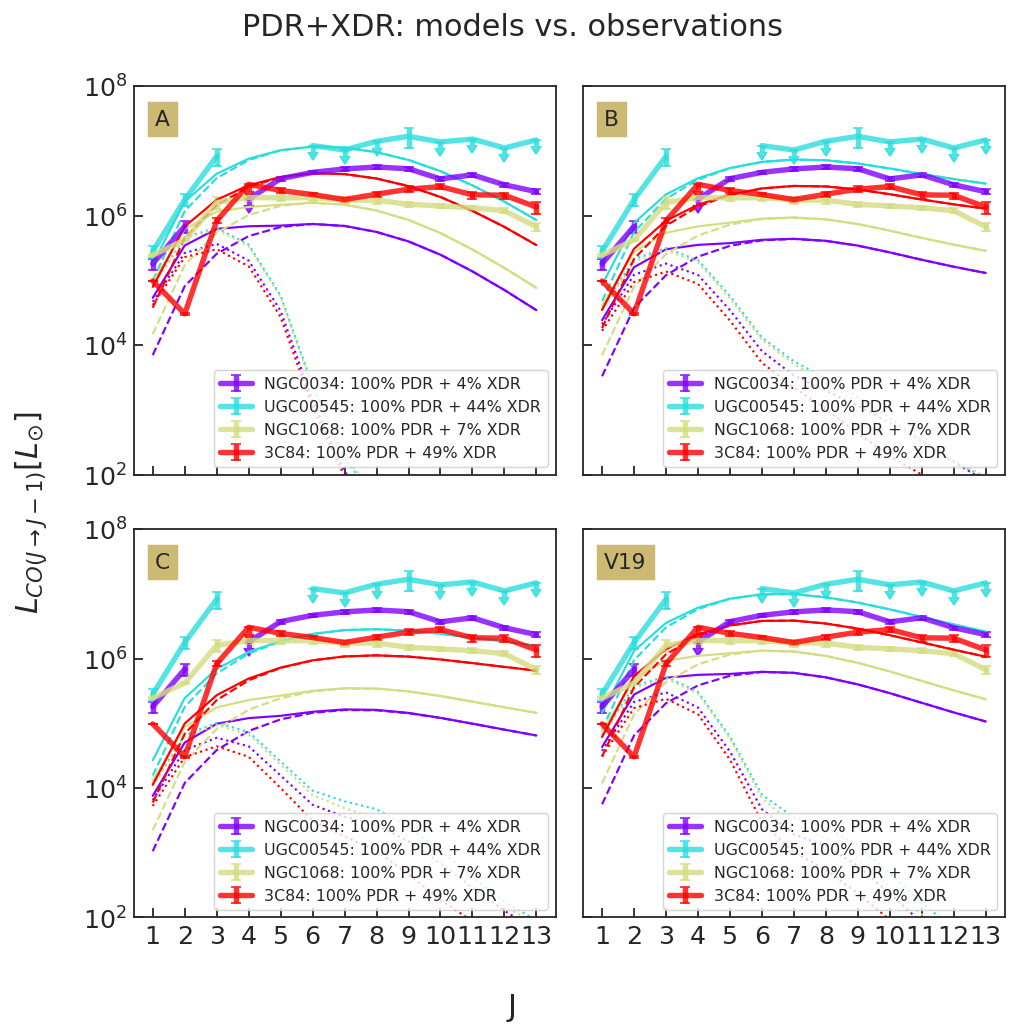

In [31]:
from gmc_class import *
Xco = 2 # 1e20 cm-2/(K.km/s)
df = pd.read_csv('../AGN_impact_CO_sample/datasets/cat_2022c.csv', index_col='Name')
sers = pd.read_csv('/media/phd/catalogo/sersic_fit.csv', index_col='Name').drop(['Circinus', 'NGC4945'])
glist = [x for x in df['CO1'].dropna().index if x in frozenset(sers.index)][:4]
colist, lo, hi, ulim = [['CO1tot' + suf] + ['CO' + str(x) + suf for x in np.arange(2,14)] 
                        for suf in ['', '_lo', '_up', '_ulim']]

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharey=True, sharex=True)

for gmc, ax in zip(gmclist, [ax1, ax2, ax3, ax4]):
    pdr_gmc, xdr_gmc = gmc.pdr_xdr()
    for g, c in zip(glist, cm.rainbow(np.linspace(0, 1, len(glist)))):
        Mmol_tot, rCO, SFR, logLX = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR', 'logLX']]
        Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
        logLX_1_100 = logLX - np.log10(0.256)
        Npdr = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR)
        Nxdr = gmc.galaxy_xdr(logLX_1_100, rCO, Mmol_tot)
        myPDR = (Npdr.loc[pdr_gmc.index] * pdr_gmc.T).T.sum()
        myXDR = (Nxdr.loc[xdr_gmc.index] * xdr_gmc.T).T.sum()
        ax.plot(np.arange(1,14), myPDR[:13], ls='dotted', color=c)
        ax.plot(np.arange(1,14), myXDR[:13], ls='dashed', color=c)
        ax.plot(np.arange(1,14), myPDR[:13] + myXDR[:13], ls='solid', color=c)
        lab = g + ': %.0f' % (100*Npdr[:-1].sum()/Npdr.sum()) + '% PDR'
        lab += ' + %.0f' % (100*Nxdr[:-1].sum()/Nxdr.sum()) + '% XDR'
        ax.errorbar(np.arange(1,14), df.loc[g, colist], color=c, capsize=3, lw=3, alpha=.8,
                     yerr = [df.loc[g, lo], df.loc[g, hi]], uplims = df.loc[g, ulim], label=lab)
    ax.set_yscale('log')
    ax.set_xticks(np.arange(1,14))
    ax.text(x=0.05, y=0.9, s=gmc.name, transform=ax.transAxes, size=12, backgroundcolor='y')
    ax.legend(loc='lower right')
    ax.set_ylim([1e2, 1e8])
fig.suptitle('PDR+XDR: models vs. observations')
fig.supxlabel('J')
fig.supylabel(r'$L_{CO(J \rightarrow J-1)} [L_{\odot}]$')
fig.tight_layout();

plt.savefig('GMCs_PDR_XDR_4gals.png', dpi=300, bbox_inches='tight')

## PDR+XDR combined for each galaxy

In [1]:
from gmc_module import *

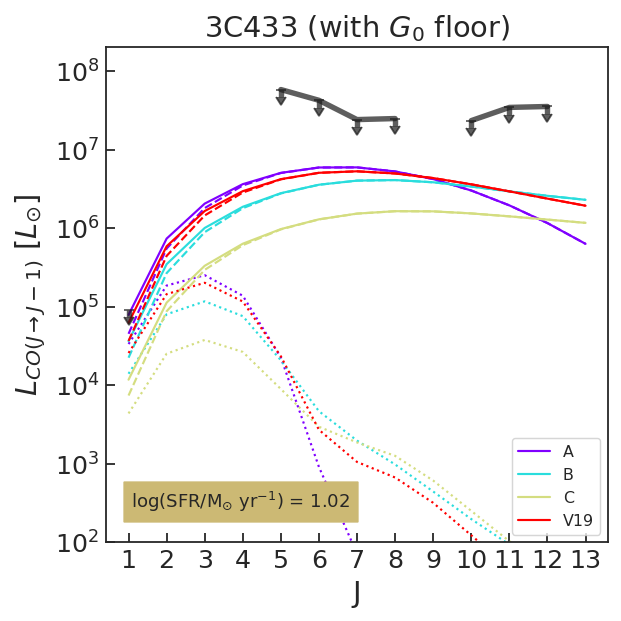

In [2]:
savefig = False
G0floor = True
Xco = 2 # 1e20 cm-2/(K.km/s)
df = pd.read_csv('../AGN_impact_CO_sample/datasets/cat_2022c.csv', index_col='Name')
sers = pd.read_csv('/media/phd/catalogo/sersic_fit.csv', index_col='Name').drop(['Circinus', 'NGC4945'])
glist = [x for x in df['CO1'].dropna().index if x in frozenset(sers.index)]
colist, lo, hi, ulim = [['CO1tot' + suf] + ['CO' + str(x) + suf for x in np.arange(2,14)] 
                        for suf in ['', '_lo', '_up', '_ulim']]

for g in ['3C433']:
    Mmol_tot, rCO, SFR, logLX = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR', 'logLX']]
    Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
    logLX_1_100 = logLX - np.log10(0.256)
    fig, ax = plt.subplots(figsize=(5,5))
    for gmc, c in zip(gmclist, cm.rainbow(np.linspace(0, 1, len(gmclist)))):
        pdr_gmc, xdr_gmc = gmc.pdr_xdr()
        Npdr = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=G0floor)
        Nxdr = gmc.galaxy_xdr(logLX_1_100, rCO, Mmol_tot)
        myPDR = (Npdr.loc[pdr_gmc.index] * pdr_gmc.T).T.sum()
        myXDR = (Nxdr.loc[xdr_gmc.index] * xdr_gmc.T).T.sum()
        ax.plot(np.arange(1,14), myPDR[:13], ls='dotted', color=c)
        ax.plot(np.arange(1,14), myXDR[:13], ls='dashed', color=c)
        ax.plot(np.arange(1,14), myPDR[:13] + myXDR[:13], ls='solid', color=c, label=gmc.name)
        if G0floor:
            ax.text(x=0.05, y=0.07, transform=ax.transAxes, size=10, backgroundcolor='y',
                    s = r'log(SFR/M$_{\odot}$ yr$^{-1}$) = %.2f' % (np.log10(SFR)))
    ax.errorbar(np.arange(1,14), df.loc[g, colist], color='k', capsize=3, lw=3, alpha=.7,
                 yerr = [df.loc[g, lo], df.loc[g, hi]], uplims = df.loc[g, ulim])
    ax.set_yscale('log')
    ax.set_xticks(np.arange(1,14))
    ax.legend(loc='lower right')
    ax.set_ylim([1e2, 2e8])
    if G0floor: ax.set_title(g + r' (with $G_0$ floor)')
    else: ax.set_title(g + r' (no $G_0$ floor)')
    ax.set_xlabel('J')
    ax.set_ylabel(r'$L_{CO(J \rightarrow J-1)}$ $[L_{\odot}]$')
    fig.tight_layout();
    if savefig:
        if G0floor:
            plt.savefig('./galaxies_plots/' + g + '_GMCs_PDR_XDR_G0floor.png', 
                        dpi=300, bbox_inches='tight')
        else:
            plt.savefig('./galaxies_plots_nofloor/' + g + '_GMCs_PDR_XDR_NOfloor.png', 
                        dpi=300, bbox_inches='tight')
        plt.close();

# Check the effect of G0 floor <a class="anchor" id="G0floor"></a>
([back to top](#toc))

We plot here the number of PDR-GMCs, for a given GMC (e.g. V19), as a function of the galactic radius, with and without the G0 floor

In [1]:
from gmc_class import *

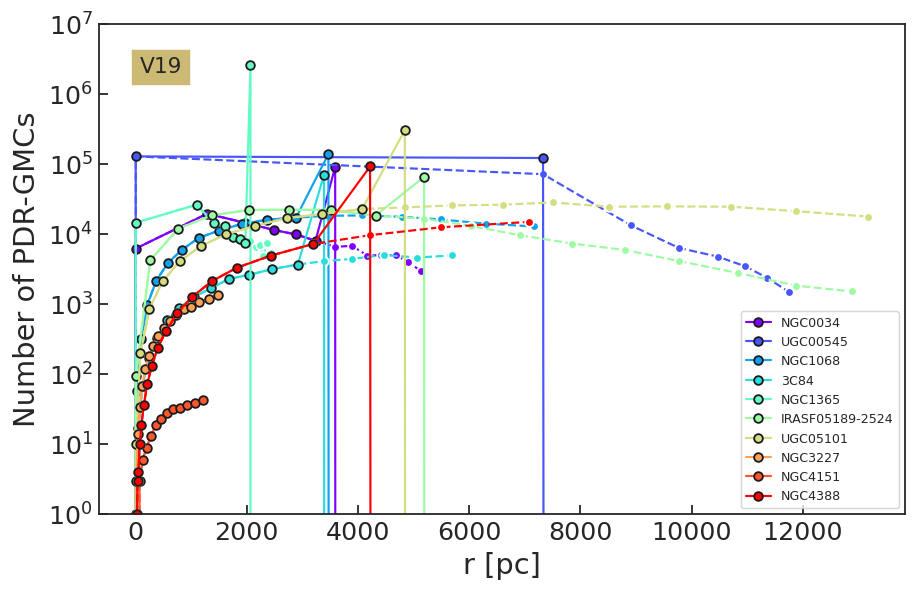

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
gmc = gmcV19

df = pd.read_csv('../AGN_impact_CO_sample/datasets/cat_2022c.csv', index_col='Name')
sers = pd.read_csv('/media/phd/catalogo/sersic_fit.csv', index_col='Name').drop(['Circinus', 'NGC4945'])
glist = [x for x in df['CO1'].dropna().index if x in frozenset(sers.index)][:10]
logG0 = np.arange(0, 6.2, 0.25)[::-1] # from the Cloudy grid [log(1.6e-3 erg/s/cm2)]
res1, res2 = [], []
for g, c in zip(glist, cm.rainbow(np.linspace(0, 1, len(glist)))):
    Mmol_tot, rCO, SFR = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR']]
    Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
    N1 = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=False)
    N2 = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=True)
    radii = r_G0(Ie, Re, n)[0]
    ax.plot(1e3 * radii, N1[:-1], marker='o', mec='w', color=c, ls='dashed')
    ax.plot(1e3 * radii, N2[:-1], marker='o', mec='k', color=c, ls='solid', label=g)
ax.set_xlabel('r [pc]')
ax.set_ylabel('Number of PDR-GMCs')
ax.set_yscale('log')
ax.text(x=0.05, y=0.9, s=gmc.name, transform=ax.transAxes, size=12, backgroundcolor='y')
ax.set_ylim([1e0, 1e7])
ax.legend(fontsize=7);

Let's check for a single galaxy what is happening

In [26]:
from gmc_class import *

In [26]:
g = 'NGC1365'
gmc = gmcV19
df = pd.read_csv('../AGN_impact_CO_sample/datasets/cat_2022c.csv', index_col='Name')
sers = pd.read_csv('/media/phd/catalogo/sersic_fit.csv', index_col='Name').drop(['Circinus', 'NGC4945'])
logG0 = np.arange(0, 6.2, 0.25)[::-1] # from the Cloudy grid [log(1.6e-3 erg/s/cm2)]
Mmol_tot, rCO, SFR, logLX = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR', 'logLX']]
logLX_1_100 = logLX - np.log10(0.256)
Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
N1 = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=False)
N2 = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=True)
Nxdr = gmc.galaxy_xdr(logLX_1_100, rCO, Mmol_tot)
radii = r_G0(Ie, Re, n)[0]
radii_min = r_G0(Ie, Re, n)[1]
radii_max = r_G0(Ie, Re, n)[2]
logFX = np.arange(-1, 4.2, 0.25)[::-1] # from the Cloudy grid [log(erg/s/cm2)]
logRXticks = 0.5 * (logLX_1_100 - logFX - np.log10(4*np.pi)) - np.log10(1e3*pc) # log(kpc)
radii_xdr = 10**logRXticks
Mmol = Mmol_tot * (1 - (np.exp(-radii_max/rCO) * (radii_max/rCO + 1)))
Ngmc = (Mmol / gmc.M).astype('int') # truncated integer

print(g, 'with GMC', gmc.name)
print('Total molecular mass = %.2E' % Mmol_tot + ' Msun')
print('which is %.0f' % (Mmol_tot/gmc.M).astype('int') + ' GMCs' + 
     ' (GMC mass is %.2E' % gmc.M + ' Msun)')
print('N_PDRs without G0 floor = ', N1[:-1].sum())
print('N_PDRs with G0 floor = ', N2[:-1].sum())
print('N_XDRs = ', Nxdr[:-1].sum())

NGC1365 with GMC V19
Total molecular mass = 2.64E+11 Msun
which is 2643452 GMCs (GMC mass is 1.00E+05 Msun)
N_PDRs without G0 floor =  132263
N_PDRs with G0 floor =  2643452
N_XDRs =  23005


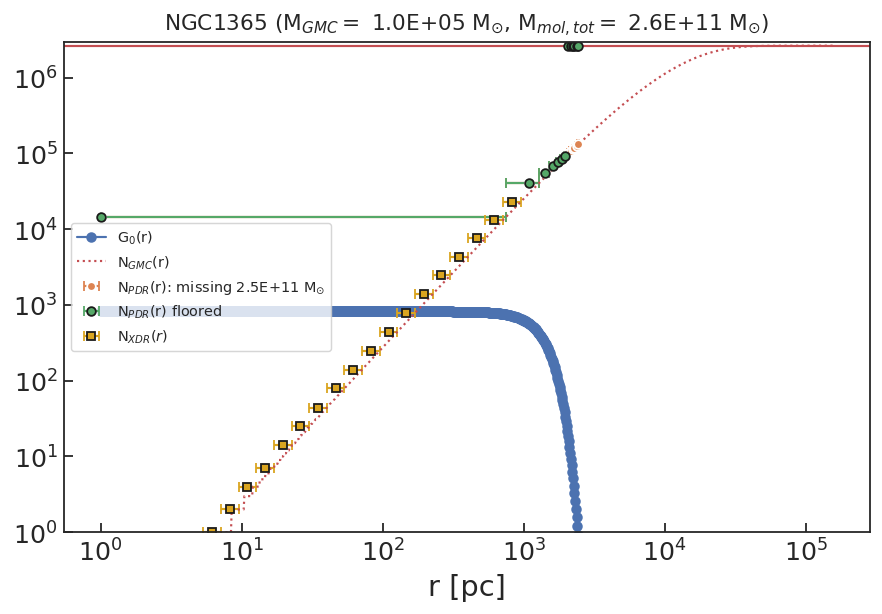

In [27]:
sersic_f = Sersic1D(amplitude=Ie, r_eff=Re, n=n)
r = 10**np.arange(-3, 2.2, 0.005) # kpc
G0_r = np.array([sersic_f(x) for x in r]) / 1.6e-3
miss = N1[-1] * gmc.M
Mmol_r = Mmol_tot * (1 - (np.exp(-r/rCO) * (r/rCO + 1)))
Ngmc_r = (Mmol_r / gmc.M).astype('int')

fig = plt.figure(figsize=(8,5))
plt.plot(1e3 * r, G0_r, '-o', label=r'G$_0$(r)')
plt.errorbar(1e3 * radii, np.cumsum(N1[:-1]), 
             xerr = [1e3 * (radii - radii_min), 1e3 * (radii_max - radii)], capsize=3,
             fmt='o', mec='w', label=r'N$_{PDR}$(r): missing %.1E' % miss + ' M$_{\odot}$')
plt.errorbar(1e3 * radii, np.cumsum(N2[:-1]), 
             xerr = [1e3 * (radii - radii_min), 1e3 * (radii_max - radii)], capsize=3,
             fmt='o', mec='k', label=r'N$_{PDR}$(r) floored')
plt.errorbar(1e3 * radii_xdr, np.cumsum(Nxdr[:-1]), 
             xerr = [1e3 * radii_xdr * (1-10**(-0.125/2)), 1e3 * radii_xdr * (10**(0.125/2) - 1)], capsize=3,
             fmt='s', c='goldenrod', mec='k', label=r'N$_{XDR}(r)$')
plt.plot(1e3 * r, Ngmc_r, ls='dotted', label=r'N$_{GMC}$(r)')
plt.axhline((Mmol_tot/gmc.M).astype('int'), c='r')
plt.ylim([1e0, 3e6])
plt.xscale('log')
plt.yscale('log')
plt.title(g + r' (M$_{GMC}=$ %.1E' % gmc.M + 
          r' M$_{\odot}$, M$_{mol,tot}=$ %.1E' % Mmol_tot + r' M$_{\odot}$)', size=12)
plt.xlabel('r [pc]')
plt.legend(fontsize=8, loc='center left');

In [48]:
pd.DataFrame({'gname': N1.index.to_list()[:-1], 
              'logG0': logG0,
              'r_min [kpc]': radii_min,
              'r(G0) [kpc]': radii,
              'r_max [kpc]': radii_max,
              'N_PDR': N1.values[:-1], 
              'N_PDR (floor)': N2.values[:-1],
              'N_GMC': np.diff(Ngmc, prepend=0)})

,gname,logG0,r_min [kpc],r(G0) [kpc],r_max [kpc],N_PDR,N_PDR (floor),N_GMC
0,g600,6.00,0.001000,0.001000,0.001000,0,0,0
1,g575,5.75,0.001000,0.001000,0.001000,0,0,0
2,g550,5.50,0.001000,0.001000,0.001000,0,0,0
3,g525,5.25,0.001000,0.001000,0.001000,0,0,0
4,g500,5.00,0.001000,0.001000,0.001000,0,0,0
5,g475,4.75,0.001000,0.001000,0.001000,0,0,0
6,g450,4.50,0.001000,0.001000,0.001000,0,0,0
7,g425,4.25,0.001000,0.001000,0.001000,0,0,0
8,g400,4.00,0.001000,0.001000,0.001000,0,0,0
9,g375,3.75,0.001000,0.001000,0.001000,0,0,0


# PROBLEM: missing CO(1-0) flux <a class="anchor" id="CO1"></a>
([back to top](#toc))

In [1]:
from gmc_module import *

#### How much CO(1-0) luminosity is missing exactly?

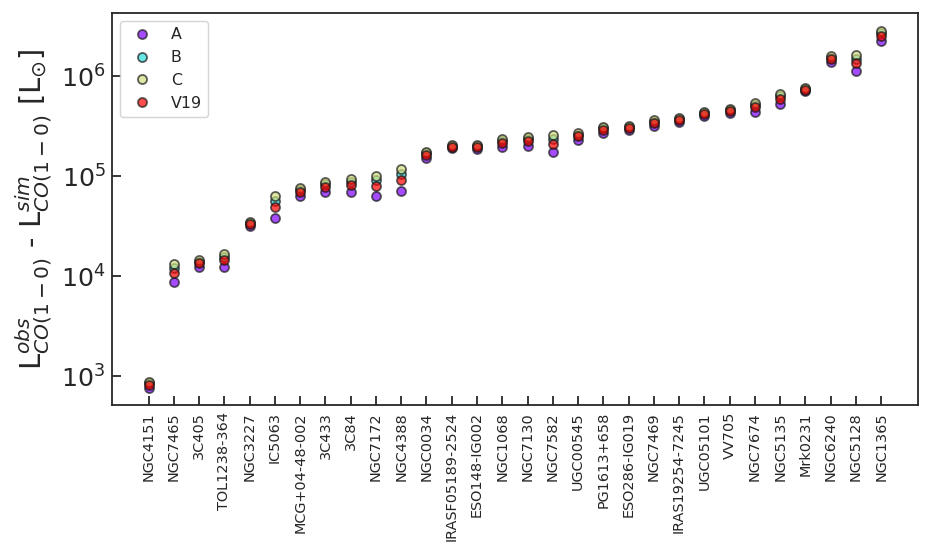

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

glist = df[['CO1tot', 'G0']].dropna().sort_values(by='CO1tot').index
for gmc, c in zip(gmclist, cm.rainbow(np.linspace(0,1,len(gmclist)))):
    pdr_gmc, xdr_gmc = gmc.pdr_xdr(units='lsun', icm=False)
    CO1_gals = pd.Series(index=glist, dtype=np.float64)
    for g in glist:
        Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
        Mmol_tot, rCO, SFR = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR']]
        Npdr = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=True)
        CO1 = sum(Npdr.loc[pdr_gmc.index] * pdr_gmc['CO1'])
        CO1_gals.loc[g] = df.loc[g, 'CO1tot'] - CO1
    
    ax.plot(CO1_gals.index, CO1_gals, color=c, label=gmc.name, 
            marker='o', ls='', ms=5, mec='k', alpha=.7)
    ax.set_yscale('log')
    ax.xaxis.set_ticks(ax.get_xticks())
    ax.xaxis.set_ticklabels(CO1_gals.index, rotation=90, size=8)
    ax.legend()
    ax.set_ylabel(r'L$_{CO(1-0)}^{obs}$ - L$_{CO(1-0)}^{sim}$ [L$_{\odot}$]');

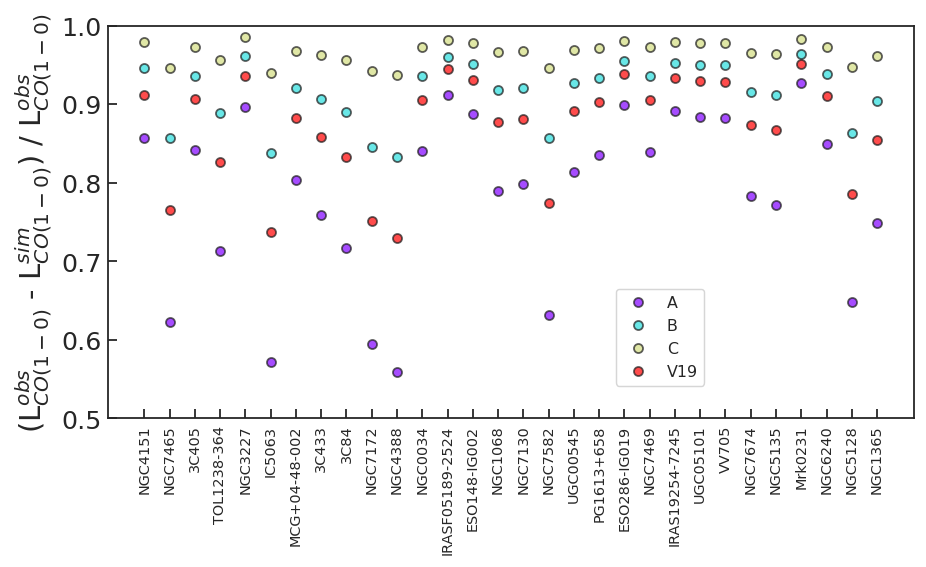

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

glist = df[['CO1tot', 'G0']].dropna().sort_values(by='CO1tot').index
for gmc, c in zip(gmclist, cm.rainbow(np.linspace(0,1,len(gmclist)))):
    pdr_gmc, xdr_gmc = gmc.pdr_xdr(units='lsun', icm=False)
    CO1_gals = pd.Series(index=glist, dtype=np.float64)
    for g in glist:
        Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
        Mmol_tot, rCO, SFR = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR']]
        Npdr = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=True)
        CO1 = sum(Npdr.loc[pdr_gmc.index] * pdr_gmc['CO1'])
        CO1_gals.loc[g] = df.loc[g, 'CO1tot'] - CO1
    
    ax.plot(CO1_gals.index, CO1_gals/df.loc[glist, 'CO1tot'], color=c, label=gmc.name, 
            marker='o', ls='', ms=5, mec='k', alpha=.7)
    #ax.set_yscale('log')
    ax.set_ylim([.5, 1])
    ax.xaxis.set_ticks(ax.get_xticks())
    ax.xaxis.set_ticklabels(CO1_gals.index, rotation=90, size=8)
    ax.legend(bbox_to_anchor=(0.75, 0.35))
    ax.set_ylabel(r'(L$_{CO(1-0)}^{obs}$ - L$_{CO(1-0)}^{sim}$) / L$_{CO(1-0)}^{obs}$');

In [106]:
glist

Index(['NGC0034', 'UGC00545', 'NGC1068', '3C84', 'NGC1365', 'IRASF05189-2524',
       'UGC05101', 'NGC3227', 'NGC4151', 'NGC4388', 'TOL1238-364', 'Mrk0231',
       'NGC5128', 'NGC5135', 'VV705', 'PG1613+658', 'NGC6240',
       'IRAS19254-7245', '3C405', 'MCG+04-48-002', 'IC5063', 'ESO286-IG019',
       '3C433', 'NGC7130', 'NGC7172', 'NGC7465', 'NGC7469', 'ESO148-IG002',
       'NGC7582', 'NGC7674'],
      dtype='object', name='Name')

KeyError: 'NGC1365'

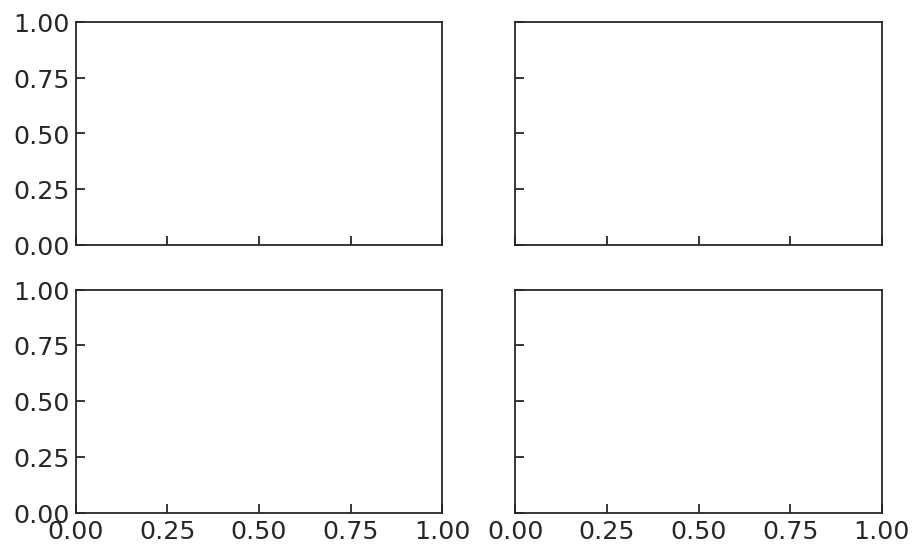

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(8,5), sharex=True, sharey=True)

for gmc, ax in zip(gmclist, axes.flatten()):
    pdr_gmc, xdr_gmc = gmc.pdr_xdr(units='lsun')
    glist = df[['CO1tot', 'G0']].dropna().index
    CO1_gals = df.loc[glist, 'CO1tot']
    for g in glist:
        Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
        Mmol_tot, rCO, SFR, = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR']]
        Npdr = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=True)
    Ngmc_gals = df['Mmol_tot_XMW'] / gmc.M
    
    
    subCO1 = df['CO1tot'] - (pdr_gmc.loc[g, 'CO1'] * Ngmc_gals)
    subCO1 = subCO1.sort_values().dropna()
    
    
    ax.plot(subCO1.index, subCO1, color=c, marker='.', ls='', ms=7, label=g)
    ax.set_yscale('log')
    ax.xaxis.set_ticks(ax.get_xticks())
    ax.xaxis.set_ticklabels(subCO1.index, rotation=90, size=5)
    ax.text(s=gmc.name, x=0.05, y=0.8, transform=ax.transAxes, size=11, backgroundcolor='y')

axes.flatten()[0].legend()
fig.supylabel(r'L$_{CO(1-0)}^{obs}$ - L$_{CO(1-0)}^{sim}$ [L$_{\odot}$]')
fig.subplots_adjust(wspace=0, hspace=0);

In [ ]:

    ax.plot(subCO1.index, subCO1, color=c, marker='.', ls='', ms=7, label=g)
    ax.set_yscale('log')
    ax.xaxis.set_ticks(ax.get_xticks())
    ax.xaxis.set_ticklabels(subCO1.index, rotation=90, size=5)
    ax.text(s=gmc.name, x=0.05, y=0.8, transform=ax.transAxes, size=11, backgroundcolor='y')

axes.flatten()[0].legend()
fig.supylabel(r'L$_{CO(1-0)}^{obs}$ - L$_{CO(1-0)}^{sim}$ [L$_{\odot}$]')
fig.subplots_adjust(wspace=0, hspace=0);

In [24]:
g = 'NGC1365'
gmc = gmcV19
sers = pd.read_csv('/media/phd/catalogo/sersic_fit.csv', index_col='Name').drop(['Circinus', 'NGC4945'])
Mmol_tot, rCO, SFR, CO1tot, logLX = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR', 'CO1tot', 'logLX']]
logLX_1_100 = logLX - np.log10(0.256)
Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
pdr_gmc, xdr_gmc = gmc.pdr_xdr()
N1 = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=False)
N2 = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=True)
N3 = gmc.galaxy_pdr_kick(N2, SFR)
Nxdr = gmc.galaxy_xdr(logLX_1_100, rCO, Mmol_tot)
CO1_nfl = (N1.loc[pdr_gmc.index] * pdr_gmc['CO1'])[::-1]
CO1_fl = (N2.loc[pdr_gmc.index] * pdr_gmc['CO1'])[::-1]
CO1_kick = (N3.loc[pdr_gmc.index] * pdr_gmc['CO1'])[::-1]
CO1_xdr = (Nxdr.loc[xdr_gmc.index] * xdr_gmc['CO1'])[::-1]
radii = r_G0(Ie, Re, n)[0]
radii_min = r_G0(Ie, Re, n)[1]
radii_max = r_G0(Ie, Re, n)[2]
logFX = np.arange(-1, 4.2, 0.25)[::-1] # from the Cloudy grid [log(erg/s/cm2)]
logRXticks = 0.5 * (logLX_1_100 - logFX - np.log10(4*np.pi)) - np.log10(1e3*pc) # log(kpc)
radii_xdr = 10**logRXticks
Mmol = Mmol_tot * (1 - (np.exp(-radii_max/rCO) * (radii_max/rCO + 1)))
Ngmc = (Mmol / gmc.M).astype('int') # truncated integer

print(g, 'with GMC', gmc.name)
print('Total molecular mass = %.2E' % Mmol_tot + ' Msun')
print('which is %.0f' % (Mmol_tot/gmc.M).astype('int') + ' GMCs' + 
     ' (GMC mass is %.2E' % gmc.M + ' Msun)')
print('N_PDRs without G0 floor = ', N1[:-1].sum())
print('N_PDRs with G0 floor = ', N2[:-1].sum())
print('N_XDRs = ', Nxdr[:-1].sum())

NGC1365 with GMC V19
Total molecular mass = 2.64E+11 Msun
which is 2643452 GMCs (GMC mass is 1.00E+05 Msun)
N_PDRs without G0 floor =  132263
N_PDRs with G0 floor =  2643452
N_XDRs =  23005


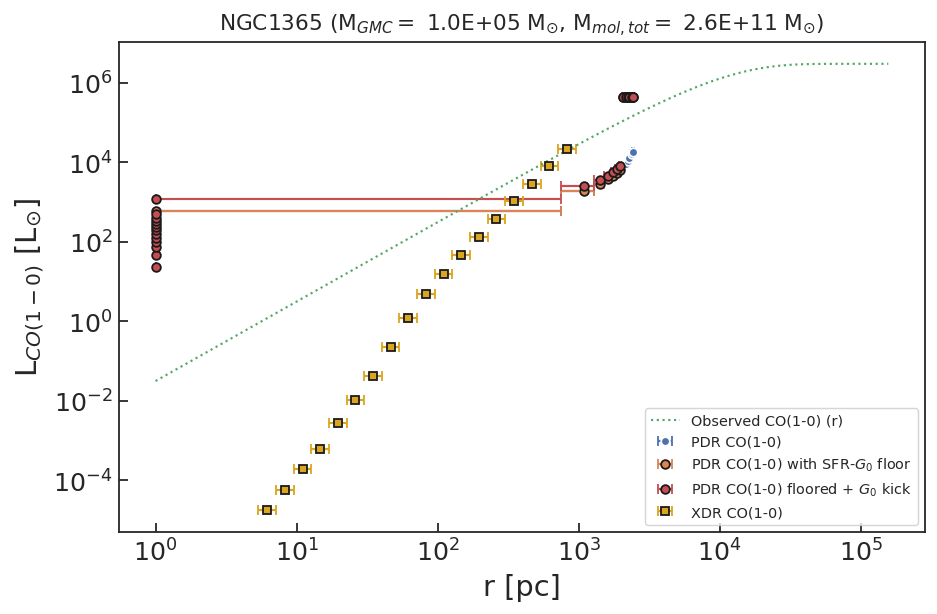

In [25]:
cumulative = True
sersic_f = Sersic1D(amplitude=Ie, r_eff=Re, n=n)
r = 10**np.arange(-3, 2.2, 0.005) # kpc
G0_r = np.array([sersic_f(x) for x in r]) / 1.6e-3
miss = N1[-1] * gmc.M
CO1_r = CO1tot * (1 - (np.exp(-r/rCO) * (r/rCO + 1)))
if cumulative:
    p1, p2, p3, p4 = [np.cumsum(x) for x in [CO1_nfl, CO1_fl, CO1_kick, CO1_xdr]]
else:
    p1, p2, p3, p4 = CO1_nfl, CO1_fl, CO1_kick, CO1_xdr
    

fig = plt.figure(figsize=(8,5))
plt.errorbar(1e3 * radii, p1, fmt='o', mec='w', label='PDR CO(1-0)',
             xerr = [1e3 * (radii - radii_min), 1e3 * (radii_max - radii)], capsize=3)
plt.errorbar(1e3 * radii, p2, fmt='o', mec='k', label=r'PDR CO(1-0) with SFR-$G_0$ floor',
             xerr = [1e3 * (radii - radii_min), 1e3 * (radii_max - radii)], capsize=3)
plt.errorbar(1e3 * radii, p3, fmt='o', mec='k', label=r'PDR CO(1-0) floored + $G_0$ kick',
             xerr = [1e3 * (radii - radii_min), 1e3 * (radii_max - radii)], capsize=3, c='r')
plt.errorbar(1e3 * radii_xdr, p4, 
             xerr = [1e3 * radii_xdr * (1-10**(-0.125/2)), 1e3 * radii_xdr * (10**(0.125/2) - 1)], capsize=3,
             fmt='s', mec='k', label='XDR CO(1-0)', c='goldenrod')
plt.plot(1e3 * r, CO1_r, ls='dotted', 
         label='Observed CO(1-0) (r)')
plt.xscale('log')
plt.yscale('log')
plt.title(g + r' (M$_{GMC}=$ %.1E' % gmc.M + 
          r' M$_{\odot}$, M$_{mol,tot}=$ %.1E' % Mmol_tot + r' M$_{\odot}$)', size=12)
plt.xlabel('r [pc]')
plt.ylabel(r'L$_{CO(1-0)}$ [L$_{\odot}$]')
plt.legend(fontsize=8, loc='lower right');

In [20]:
pd.concat([N1, N2, N3, CO1_nfl, CO1_fl, CO1_kick], axis=1)

,0,1,2,3,4,5
g600,0,0,580,0.000000,0.000000,5.612459
g575,0,0,564,0.000000,0.000000,5.686622
g550,0,0,539,0.000000,0.000000,5.751767
g525,0,0,570,0.000000,0.000000,6.410065
g500,0,0,515,0.000000,0.000000,6.268134
g475,0,0,536,0.000000,0.000000,7.172738
g450,0,0,561,0.000000,0.000000,8.371929
g425,0,0,572,0.000000,0.000000,9.872706
g400,0,0,538,0.000000,0.000000,10.982986
g375,0,0,577,0.000000,0.000000,13.778096


# PROBLEM: increase the mid-J flux <a class="anchor" id="midJ"></a>
([back to top](#toc))

Let's try to randomly insert a GMC with an high incident G0 flux, to simulate the effect of the Orion-like regions in the studied galaxies

In [1]:
from gmc_module import *

In [2]:
df.SFR.sort_values()

Name
NGC4151              0.249091
NGC3227              0.558015
NGC7465              0.761347
NGC7172              2.462755
IC5063               2.576354
NGC4388              3.713200
TOL1238-364          4.061232
IC4518a              5.571885
MCG-03-34-064        5.700135
NGC5128              6.694544
NGC7582              7.050150
3C84                 9.028768
MCG+04-48-002        9.553042
3C433               10.362701
NGC7674             15.431433
NGC1365             16.838263
NGC1068             16.998151
NGC5135             17.133929
NGC7130             22.173828
NGC0034             30.590410
UGC00545            33.822057
3C405               35.387809
NGC7469             35.426185
PG1613+658          44.226780
NGC6240             69.771545
VV705               72.135817
IRAS19254-7245     104.145936
ESO286-IG019       104.573316
UGC05101           105.177249
ESO148-IG002       107.608549
IRASF05189-2524    108.925757
Mrk0231            278.140814
IRAS07598+6508            NaN
Mrk04

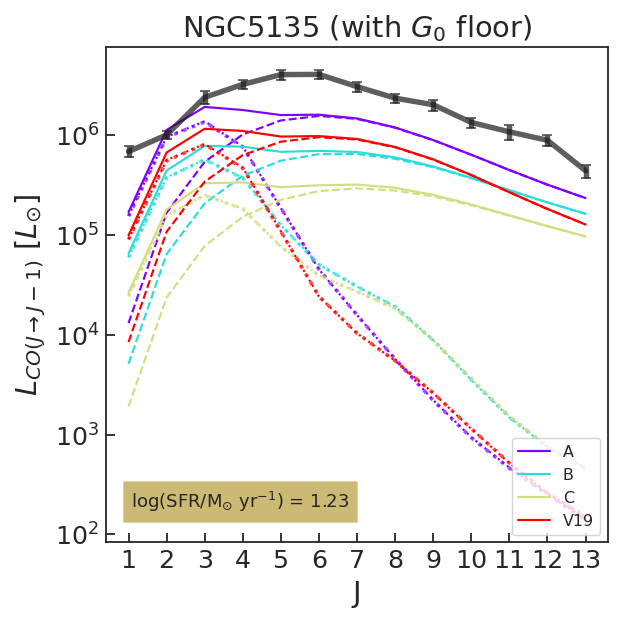

In [8]:
savefig = False
G0floor = True
Xco = 2 # 1e20 cm-2/(K.km/s)
df = pd.read_csv('../AGN_impact_CO_sample/datasets/cat_2022c.csv', index_col='Name')
sers = pd.read_csv('/media/phd/catalogo/sersic_fit.csv', index_col='Name').drop(['Circinus', 'NGC4945'])
glist = [x for x in df['CO1'].dropna().index if x in frozenset(sers.index)]
colist, lo, hi, ulim = [['CO1tot' + suf] + ['CO' + str(x) + suf for x in np.arange(2,14)] 
                        for suf in ['', '_lo', '_up', '_ulim']]

for g in ['NGC5135']:
    Mmol_tot, rCO, SFR, logLX = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR', 'logLX']]
    Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
    logLX_1_100 = logLX - np.log10(0.256)
    fig, ax = plt.subplots(figsize=(5,5))
    for gmc, c in zip(gmclist, cm.rainbow(np.linspace(0, 1, len(gmclist)))):
        pdr_gmc, xdr_gmc = gmc.pdr_xdr()
        Npdr = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=G0floor)
        Npdr_kicked = gmc.galaxy_pdr_kick(Npdr, SFR)
        Nxdr = gmc.galaxy_xdr(logLX_1_100, rCO, Mmol_tot)
        myPDR = (Npdr.loc[pdr_gmc.index] * pdr_gmc.T).T.sum()
        myPDR_kicked = (Npdr_kicked.loc[pdr_gmc.index] * pdr_gmc.T).T.sum()
        myXDR = (Nxdr.loc[xdr_gmc.index] * xdr_gmc.T).T.sum()
        ax.plot(np.arange(1,14), myPDR[:13], ls='dotted', color=c)
        ax.plot(np.arange(1,14), myPDR_kicked[:13], ls='dotted', color=c, lw=2, alpha=.7)
        ax.plot(np.arange(1,14), myXDR[:13], ls='dashed', color=c)
        ax.plot(np.arange(1,14), myPDR[:13] + myXDR[:13], ls='solid', color=c, label=gmc.name)
        if G0floor:
            ax.text(x=0.05, y=0.07, transform=ax.transAxes, size=10, backgroundcolor='y',
                    s = r'log(SFR/M$_{\odot}$ yr$^{-1}$) = %.2f' % (np.log10(SFR)))
    ax.errorbar(np.arange(1,14), df.loc[g, colist], color='k', capsize=3, lw=3, alpha=.7,
                 yerr = [df.loc[g, lo], df.loc[g, hi]], uplims = df.loc[g, ulim])
    ax.set_yscale('log')
    ax.set_xticks(np.arange(1,14))
    ax.legend(loc='lower right')
    #ax.set_ylim([1e2, 2e8])
    if G0floor: ax.set_title(g + r' (with $G_0$ floor)')
    else: ax.set_title(g + r' (no $G_0$ floor)')
    ax.set_xlabel('J')
    ax.set_ylabel(r'$L_{CO(J \rightarrow J-1)}$ $[L_{\odot}]$')
    fig.tight_layout();
    if savefig:
        if G0floor:
            plt.savefig('./galaxies_plots/' + g + '_GMCs_PDR_XDR_G0floor.png', 
                        dpi=300, bbox_inches='tight')
        else:
            plt.savefig('./galaxies_plots_nofloor/' + g + '_GMCs_PDR_XDR_NOfloor.png', 
                        dpi=300, bbox_inches='tight')
        plt.close();

In [9]:
print(SFR, Npdr.sum(), round(Npdr.sum() * SFR / 1e2))
pd.concat([Npdr, Npdr_kicked], axis=1)

17.133929049279338 611720 104812


,0,1
g600,0,547
g575,0,529
g550,0,569
g525,0,556
g500,0,540
g475,0,561
g450,0,571
g425,0,577
g400,0,553
g375,0,578


In [10]:
pd.concat([myPDR, myPDR_kicked, myPDR_kicked > myPDR], axis=1)

,0,1,2
CO1,91125.405594,89981.488137,False
CO2,564932.806368,558011.787190,False
CO3,819429.758655,809972.015110,False
CO4,473200.077155,468593.305555,False
CO5,108931.548077,108515.693302,False
CO6,24230.929331,24309.500765,True
CO7,10372.841356,10384.677718,True
CO8,5498.524759,5497.168419,False
CO9,2610.037970,2615.892523,True
CO10,1144.404429,1150.797358,True


***
***
***
***
***

# THE DIFFUSE MOLECULAR ISM

# Spreading the ICM on the galaxy scale <a class="anchor" id="spreadICM"></a>
([back to top](#toc))

### GMCs with updated lowest gas density

We have added new Cloudy runs at very low densities, extending the parameter space down to $n_H = 1$ cm$^{-3}$. This extension will affect the clumps extractions of our GMCs only for the last clump, the ICM one, which is limited by the lowest Cloudy sampled density (now 1 cm$^{-3}$, while before it was 10 cm$^{-3}$). The other clumps densities are instead limited by the $n_0$ quantity, which is unique for each GMC, and it has always been set $n_0 > 10$ cm$^{-3}$.

Down here we refer to `lo` for the new extractions ($n_{ICM} \geq 1$ cm$^{-3}$). What we try to do is to subtract the ICM clump from each GMC within a median galaxy, and to spread this molecular mass over the whole galaxy (i.e. over a volume $V = \pi r_{CO}^2 z_{CO}$) to calculate its $n$ and $N_H$.

Down here for example the distribution of clumps in the GMC V19lo

In [3]:
from gmc_module import *

V19lo


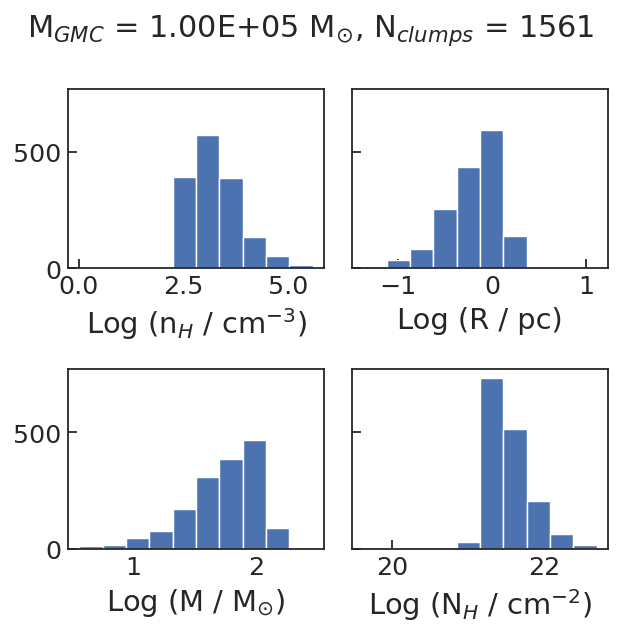

In [4]:
gmc = gmcV19lo
print(gmc.name)
ndf = pd.read_csv(gmc.ndf)
ndf_histo(ndf)

In [5]:
Mtot = df.Mmol_tot_XMW.median()
rCO = df.rCO.median() * kpc
zCO = rCO * 0.01/0.17
print('\nUsing the median values for the 35 AGN sample:')
print('Total molecular mass = %.1e Msun' % Mtot)
print('rCO = %.2f kpc    zCO = %.2f pc' % (rCO/kpc, zCO/pc))

gmcnames = [gmc.name for gmc in gmclist + gmclost]
cols = ['Mgmc', 'Nclumps', 'Ngmc', 'Micm', 'n_icm', 'logNH']
icm = pd.DataFrame(index=gmcnames, columns=cols)
for gmc in gmclist + gmclost:
    ndf = pd.read_csv(gmc.ndf)
    logMicm = ndf.iloc[-1]['logM']
    M_icm_gal = (10**logMicm) * Mtot / gmc.M
    n_icm = (msun*M_icm_gal / (zCO * pi*(rCO)**2)) / (mu*mp)
    icm.loc[gmc.name, 'Mgmc'] = gmc.M
    icm.loc[gmc.name, 'Nclumps'] = len(ndf)
    icm.loc[gmc.name, 'Ngmc'] = (Mtot / gmc.M)
    icm.loc[gmc.name, 'Micm'] = (10**logMicm) * Mtot / gmc.M
    icm.loc[gmc.name, 'n_icm'] = n_icm
    icm.loc[gmc.name, 'logNH'] = np.log10(n_icm * rCO)

icm


Using the median values for the 35 AGN sample:
Total molecular mass = 2.2e+10 Msun
rCO = 3.07 kpc    zCO = 180.50 pc


,Mgmc,Nclumps,Ngmc,Micm,n_icm,logNH
A,6200,122,3.57997e+06,1.14307e+08,0.710447,21.8278
B,99000,1178,224200,3.45834e+08,2.14945,22.3086
C,3.9e+06,22463,5691.24,2.80077e+09,17.4075,23.217
V19,100000,1555,221958,6.2405e+08,3.87863,22.565
Alo,6200,116,3.57997e+06,2.25001e+07,0.139844,21.122
Blo,99000,1219,224200,4.31555e+07,0.268223,21.4048
Clo,3.9e+06,25298,5691.24,2.17131e+08,1.34953,22.1065
V19lo,100000,1561,221958,6.34447e+07,0.394325,21.5722


### Diffuse ICM for every galaxy

For every galaxy, we subtract the ICM clump from the GMCs and we spread the sum of them over the volume of the galaxy:

$$\large
M_{mol,tot} = 8.9 \times 10^4 \, \frac{X_{CO}}{2 \times 10^{20}} \, L_{CO,tot} \\ \large
N_{GMC} = \frac{M_{mol,tot}}{M_{GMC}} \\ \large
M_{\mathrm{diffuse}} = \Sigma M_{ICM} = M_{ICM} \times N_{GMC} \\ \large
V_{mol} = 2 \pi r_{CO}^2 z_{CO} \\ \large
n_{\mathrm{diffuse}} = \frac{M_{\mathrm{diffuse}}}{V_{mol} \mu m_p}
$$

where we use a Milky Way $X_{CO} = 2 \times 10^{20}$, and $M_{GMC}$ depends on the GMC used.

In this way we have a density of this gas, necessary for extracting the right CLOUDY simulation. We can use the radius $r_{CO}$ as cloud depth and $G_0 = $ SFR as the incident flux, and calculate the diffuse CO emission for every galaxy.

In [5]:
from gmc_module import *

In [8]:
for gmc in gmclist + gmcturb:
    ndf = pd.read_csv(gmc.ndf)
    Micm = 10**ndf.iloc[-1]['logM']
    print('\033[1m' + gmc.name + '\033[0m' + 
          '\t: M(ICM clump) = %.1e Msun \t= %.1f %% of M(GMC) = %.1e Msun' % (Micm, 100*Micm/gmc.M, gmc.M))

A	: M(ICM clump) = 3.2e+01 Msun 	= 0.5 % of M(GMC) = 6.2e+03 Msun
B	: M(ICM clump) = 1.5e+03 Msun 	= 1.6 % of M(GMC) = 9.9e+04 Msun
C	: M(ICM clump) = 4.9e+05 Msun 	= 12.6 % of M(GMC) = 3.9e+06 Msun
V19	: M(ICM clump) = 2.8e+03 Msun 	= 2.8 % of M(GMC) = 1.0e+05 Msun
Aturb	: M(ICM clump) = 4.9e+01 Msun 	= 0.8 % of M(GMC) = 6.2e+03 Msun
Bturb	: M(ICM clump) = 2.4e+02 Msun 	= 0.2 % of M(GMC) = 9.9e+04 Msun
Cturb	: M(ICM clump) = 3.9e+04 Msun 	= 1.0 % of M(GMC) = 3.9e+06 Msun
V19turb	: M(ICM clump) = 2.9e+02 Msun 	= 0.3 % of M(GMC) = 1.0e+05 Msun


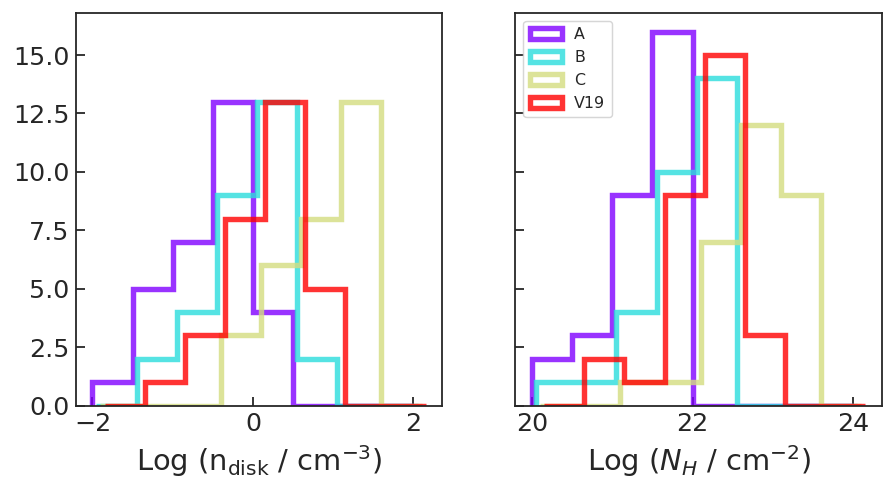

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)

glist = df[['CO1tot', 'G0']].dropna().sort_values(by='CO1tot').index
rCO = df.loc[glist, 'rCO'] * kpc
zCO = 0.01 * rCO / 0.17
Vtot = 2 * pi * zCO * rCO**2
Mtot = df.loc[glist, 'Mmol_tot_XMW']

for (lstep, gmc), c in zip(enumerate(gmclist), cm.rainbow(np.linspace(0,1,len(gmclist)))):
    ndf = pd.read_csv(gmc.ndf)
    logMicm = ndf.iloc[-1]['logM']
    M_icm_gal = (10**logMicm) * Mtot / gmc.M
    n_icm = msun*M_icm_gal / (Vtot * mu * mp)
    NH_icm = n_icm * rCO
    # spread-ICM density
    ax[0].hist(np.log10(n_icm), bins=np.arange(-2, 2.5, 0.5) + lstep/20, 
            color=c, label=gmc.name, histtype='step', lw=3, alpha=.8)
    ax[0].set_xlabel(r'Log (n$_{\mathrm{disk}}$ / cm$^{-3}$)')
    # spread-ICM mass
    #ax[1].hist(np.log10(M_icm_gal), bins=np.arange(6, 10.5, 0.5) + lstep/20, 
    #        color=c, label=gmc.name, histtype='step', lw=3, alpha=.8)
    #ax[1].set_xlabel(r'Log (M$_{\mathrm{disk}}$ / M$_{\odot}$)')
    # spread-ICM column density
    ax[1].hist(np.log10(NH_icm), bins=np.arange(20, 24.5, 0.5) + lstep/20, 
            color=c, label=gmc.name, histtype='step', lw=3, alpha=.8)
    ax[1].set_xlabel(r'Log ($N_H$ / cm$^{-2}$)')
    #ax.set_yscale('log')
    ax[1].legend(loc='upper left');
    #ax.set_ylabel(r'');

#### Calculate the CO SLED of the spread ICM for every galaxy and GMC (if the gas density is high enough)

In [1]:
from gmc_module import *

In [10]:
# this cell does what the previous cell functions does --> delete it?

glist = [x for x in df['CO1'].dropna().index if x in frozenset(sers.index)]
pwrt = '/media/phd/jupyter/claudia/icm_sleds/'
wd = '/media/phd/cloudy/ngmgrid/'
sww = pd.read_csv(wd + 'swwlist.csv', header=None)[0].to_list()
sww = [s.replace('.out', '') for s in sww]
Jmax = 13
COls = ['CO' + str(c) for c in np.arange(1,Jmax+1)]
logNH = 22.5

pbar = ProgressBar()
for galaxy in pbar(glist):
    exbase = pwrt + galaxy + '_icmSLED_'
    
    # the radius for extracting the Cloudy output
    rCO = df.loc[galaxy, 'rCO'] * kpc
    zCO = 0.01 * rCO / 0.17
    Vtot = 2 * pi * zCO * rCO**2
    Mtot = df.loc[galaxy, 'Mmol_tot_XMW']
    logRCO = np.log10(rCO)
    
    for gmc in gmcturb:
        ndf = pd.read_csv(gmc.ndf)
        logMicm = ndf.iloc[-1]['logM']
        M_icm_gal = (10**logMicm) * Mtot / gmc.M
        n_icm = msun*M_icm_gal / (Vtot * mu * mp)
        if n_icm >= 10**(-0.125): # density threshold
            logn = np.log10(n_icm)
            logR = [logRCO, logNH - logn][0] # 0 if rCO, 1 if fixed logNH
            if logn < 0: logn = 0.00001
            hh = [hden[hden < logn].max(), hden[hden > logn].min()]
            extract = pd.DataFrame(index=gnames[::-1], columns=COls)
            for g in gnames:
                ff = ['pdr_h%03d_' % (h*1e2) + g for h in hh]
                Hsleds = np.array([sww_NH(wd, fname, logNH, sww, Jmax)[2] for fname in ff])
                thisSLED = paramSLED(ff[0], ff[1], Hsleds, logn, Jmax)
                extract.loc[g] = np.array(thisSLED)
            extract = extract * 4*pi*(10**logRCO)**2 / lsun # luminosity is integrated over rCO
            extract.to_csv(exbase + gmc.name + '_PDR.csv')
            extract = pd.DataFrame(index=xnames[::-1], columns=COls)
            for x in xnames:
                ff = ['xdr_h%03d_' % (h*1e2) + x for h in hh]
                Hsleds = np.array([sww_NH(wd, fname, logNH, sww, Jmax)[2] for fname in ff])
                thisSLED = paramSLED(ff[0], ff[1], Hsleds, logn, Jmax)
                extract.loc[x] = np.array(thisSLED)
            extract = extract * 4*pi*(10**logRCO)**2 / lsun # luminosity is integrated over rCO
            extract.to_csv(exbase + gmc.name + '_XDR.csv')

100% |#########################################################################|


#### How much CO(1-0) is missing? (black contours if ICM is spread, white if within GMCs)

In [2]:
from gmc_module import *

In [24]:
def pdr_line_gals(line_name, gmcs, G0floor=True, G0kick=False, spreadICM=True, logNH=None):
    '''
    Returns (and saves) a dataframe with a single line luminosity
    for every galaxy for given list of GMCs
    '''
    glist = [x for x in df['CO1'].dropna().index if x in frozenset(sers.index)]
    picm = '/media/phd/jupyter/claudia/icm_sleds/'
    if logNH: picm = picm[:-1] + '_logNH%3d' % (logNH*10) + '/'
    pdr_csv = picm + line_name + '_Lsun_PDR'
    if G0floor: pdr_csv += '_G0floor'
    if G0kick: pdr_csv += '_G0kick'
    if spreadICM: pdr_csv += '_spreadICM'
    try:
        line_gals = pd.read_csv(pdr_csv + '.csv', index_col=0)
    except FileNotFoundError:
        line_gals = pd.DataFrame(index=glist, columns=[gmc.name for gmc in gmcs])
        pbar = ProgressBar()
        for gmc in pbar(gmcs):
            for g in glist:
                exbase = picm + g + '_icmSLED_'
                Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
                Mmol_tot, rCO, SFR = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR']]
                gSFR = logG0[np.abs(np.log10(SFR) - logG0).argmin()]
                Npdr = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=G0floor)
                if G0kick: print('--->  !!! Please implement G0kick !!!  <---')
                if spreadICM:
                    try:
                        pdr_icm = gmc.icm_sled(g, logNH=logNH)[0]
                        pdr_gmc = gmc.pdr_xdr(icm=False)[0]
                        this_line = sum(Npdr.loc[pdr_gmc.index] * pdr_gmc[line_name])
                        this_line += pdr_icm.loc['g%03d' % (1e2*gSFR), line_name]
                    except Exception:
                        pdr_gmc = gmc.pdr_xdr(icm=True)[0]
                        this_line = sum(Npdr.loc[pdr_gmc.index] * pdr_gmc[line_name])
                else:
                    pdr_gmc = gmc.pdr_xdr(icm=True)[0]
                    this_line = sum(Npdr.loc[pdr_gmc.index] * pdr_gmc[line_name])
                line_gals.loc[g, gmc.name] = this_line
        line_gals.to_csv(pdr_csv + '.csv')
    return line_gals

In [25]:
CO1_gals = pdr_line_gals('CO1', gmcs = gmclist + gmcturb)

In [26]:
# dataframe with CO(1-0) PDR luminosity with G0floor, no G0kick, spreadICM when log(nICM) >= -0.125
savecsv = True
pwrt = '/media/phd/jupyter/claudia/icm_sleds/'
glist = df[['CO1tot', 'G0']].dropna().sort_values(by='CO1tot').index
CO1_gals = pd.DataFrame(index=glist, columns=[gmc.name for gmc in gmclist + gmcturb])

pbar = ProgressBar()
for gmc in pbar(gmclist + gmcturb):
    for g in glist:
        exbase = pwrt + g + '_icmSLED_'
        Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
        Mmol_tot, rCO, SFR = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR']]
        gSFR = logG0[np.abs(np.log10(SFR) - logG0).argmin()]
        Npdr = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=True)
        try:
            pdr_icm = pd.read_csv(exbase + gmc.name + '_PDR.csv', index_col=0)
            pdr_gmc = gmc.pdr_xdr(icm=False)[0]
            CO1 = sum(Npdr.loc[pdr_gmc.index] * pdr_gmc['CO1'])
            CO1 += pdr_icm.loc['g%03d' % (1e2*gSFR), 'CO1']
        except FileNotFoundError:
            pdr_gmc = gmc.pdr_xdr(icm=True)[0]
            CO1 = sum(Npdr.loc[pdr_gmc.index] * pdr_gmc['CO1'])
        CO1_gals.loc[g, gmc.name] = CO1

if savecsv:
    CO1_gals.to_csv(pwrt + 'CO1_Lsun_PDR_G0floor_noG0kick_spreadICM.csv')

100% |#########################################################################|


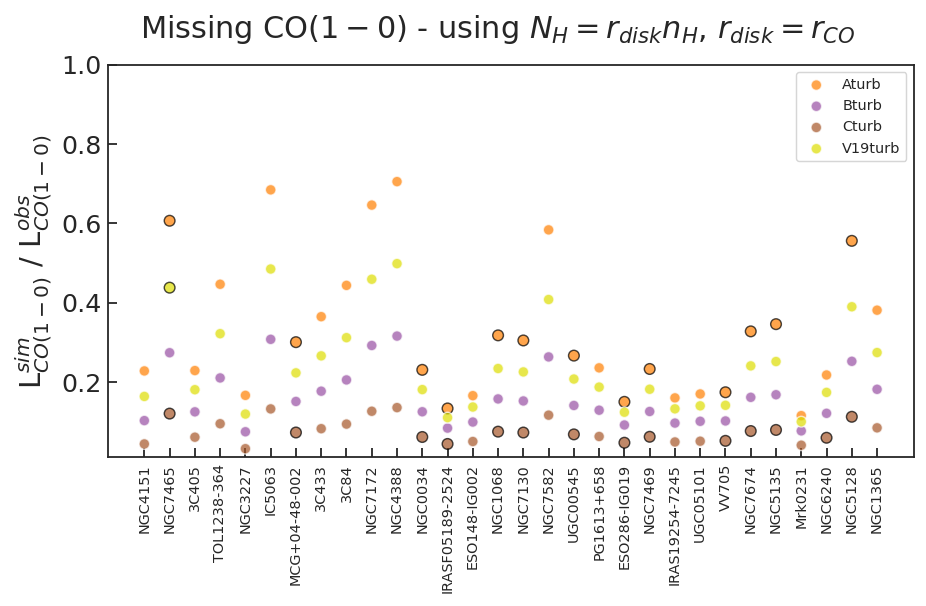

In [27]:
picm = '/media/phd/jupyter/claudia/icm_sleds/'
CO1_gals = pd.read_csv(picm + 'CO1_Lsun_PDR_G0floor_noG0kick_spreadICM.csv', index_col=0)
#CO1_gals = pdr_line_gals('CO1', gmcs = gmclist + gmcturb)

gmcs = gmcturb
fig, ax = plt.subplots(1, 1, figsize=(8,4))

for gmc, c in zip(gmcs, CBlist1[:len(gmcs)]):
    mecs = []
    for g in CO1_gals.index:
        if os.path.isfile(picm + g + '_icmSLED_' + gmc.name + '_PDR.csv'): mecs.append(1)
        else: mecs.append(0)
    
    ax.scatter(CO1_gals.index, CO1_gals[gmc.name]/df.loc[CO1_gals.index, 'CO1tot'], 
               c=c, label=gmc.name, marker='o', s=35, alpha=.7,
               edgecolors=cm.Greys(np.array(mecs, dtype=np.float64)))
    #ax.set_yscale('log')
    ax.set_ylim([1e-2, 1e0])
    ax.xaxis.set_ticks(ax.get_xticks())
    ax.xaxis.set_ticklabels(CO1_gals.index, rotation=90, size=8)
    ax.legend(fontsize=8)
    ax.set_ylabel(r'L$_{CO(1-0)}^{sim}$ / L$_{CO(1-0)}^{obs}$');
fig.suptitle(r'Missing CO($1-0$) - using $N_H = r_{disk} n_H$, $r_{disk} = r_{CO}$');

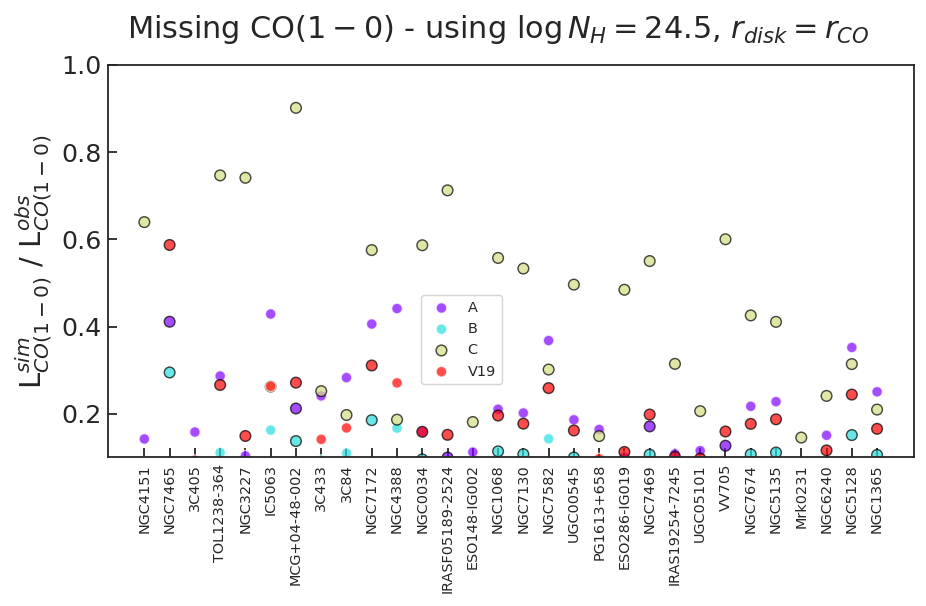

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

glist = df[['CO1tot', 'G0']].dropna().sort_values(by='CO1tot').index
for gmc, c in zip(gmclist, cm.rainbow(np.linspace(0,1,len(gmclist)))):
    CO1_gals = pd.Series(index=glist, dtype=np.float64)
    mecs = []
    for g in glist:
        exbase = '/media/phd/jupyter/claudia/icm_sleds_logNH245_rCO/' + g + '_icmSLED_'
        Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
        Mmol_tot, rCO, SFR = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR']]
        gSFR = logG0[np.abs(np.log10(SFR) - logG0).argmin()]
        Npdr = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=True)
        try:
            pdr_icm = pd.read_csv(exbase + gmc.name + '_PDR.csv', index_col=0)
            pdr_gmc = gmc.pdr_xdr(icm=False)[0]
            CO1 = sum(Npdr.loc[pdr_gmc.index] * pdr_gmc['CO1'])
            CO1 += pdr_icm.loc['g%03d' % (1e2*gSFR), 'CO1']
            mecs.append(1)
        except FileNotFoundError:
            pdr_gmc = gmc.pdr_xdr(icm=True)[0]
            CO1 = sum(Npdr.loc[pdr_gmc.index] * pdr_gmc['CO1'])
            #pdr_icm = gmc.pdr_xdr_clumps(only_icm=True)[0][0]
            #CO1 = sum(Npdr.loc[pdr_icm.index] * pdr_icm['CO1'])
            mecs.append(0)
        CO1_gals.loc[g] = CO1 / df.loc[g, 'CO1tot']
    
    ax.scatter(CO1_gals.index, CO1_gals, color=c, label=gmc.name, 
            marker='o', s=35, edgecolors=cm.Greys(np.array(mecs, dtype=np.float64)), alpha=.7)
    #ax.set_yscale('log')
    ax.set_ylim([0.1, 1])
    ax.xaxis.set_ticks(ax.get_xticks())
    ax.xaxis.set_ticklabels(CO1_gals.index, rotation=90, size=8)
    ax.legend(bbox_to_anchor=(0.38, 0.3), fontsize=8)
    #ax.set_ylabel(r'(L$_{CO(1-0)}^{obs}$ - L$_{CO(1-0)}^{sim}$) / L$_{CO(1-0)}^{obs}$');
    ax.set_ylabel(r'L$_{CO(1-0)}^{sim}$ / L$_{CO(1-0)}^{obs}$');
fig.suptitle(r'Missing CO($1-0$) - using $\log N_H = 24.5$, $r_{disk} = r_{CO}$');

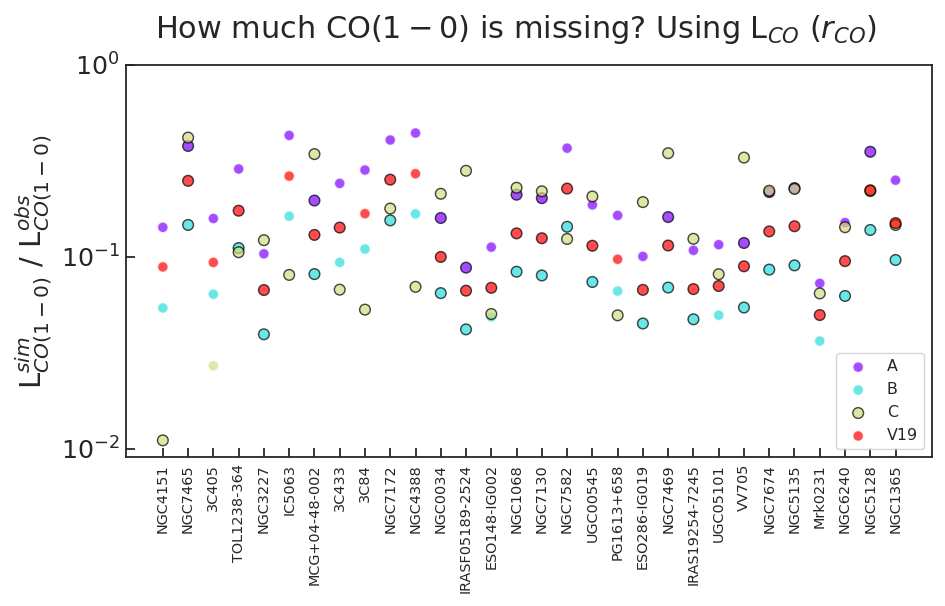

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

glist = df[['CO1tot', 'G0']].dropna().sort_values(by='CO1tot').index
for gmc, c in zip(gmclist, cm.rainbow(np.linspace(0,1,len(gmclist)))):
    CO1_gals = pd.Series(index=glist, dtype=np.float64)
    mecs = []
    for g in glist:
        exbase = '/media/phd/jupyter/claudia/icm_sleds/' + g + '_icmSLED_'
        Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
        Mmol_tot, rCO, SFR = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR']]
        gSFR = logG0[np.abs(np.log10(SFR) - logG0).argmin()]
        Npdr = gmc.galaxy_pdr(Ie, Re, n, rCO, 0.26424*Mmol_tot, SFR, G0floor=True)
        try:
            pdr_icm = pd.read_csv(exbase + gmc.name + '_PDR.csv', index_col=0)
            pdr_gmc = gmc.pdr_xdr(icm=False)[0]
            CO1 = sum(Npdr.loc[pdr_gmc.index] * pdr_gmc['CO1'])
            CO1 += pdr_icm.loc['g%03d' % (1e2*gSFR), 'CO1']
            mecs.append(1)
        except FileNotFoundError:
            pdr_gmc = gmc.pdr_xdr(icm=True)[0]
            CO1 = sum(Npdr.loc[pdr_gmc.index] * pdr_gmc['CO1'])
            mecs.append(0)
        CO1_gals.loc[g] = CO1 / df.loc[g, 'CO1rCO']
    
    ax.scatter(CO1_gals.index, CO1_gals, color=c, label=gmc.name, 
            marker='o', s=35, edgecolors=cm.Greys(np.array(mecs, dtype=np.float64)), alpha=.7)
    ax.set_yscale('log')
    ax.set_ylim([9e-3, 1])
    ax.xaxis.set_ticks(ax.get_xticks())
    ax.xaxis.set_ticklabels(CO1_gals.index, rotation=90, size=8)
    ax.legend(loc='lower right')
    #ax.set_ylabel(r'(L$_{CO(1-0)}^{obs}$ - L$_{CO(1-0)}^{sim}$) / L$_{CO(1-0)}^{obs}$');
    ax.set_ylabel(r'L$_{CO(1-0)}^{sim}$ / L$_{CO(1-0)}^{obs}$');
fig.suptitle(r'How much CO($1-0$) is missing? Using L$_{CO}$ ($r_{CO}$)');

#### The CO SLED of a single galaxy with spread ICM (when possible)

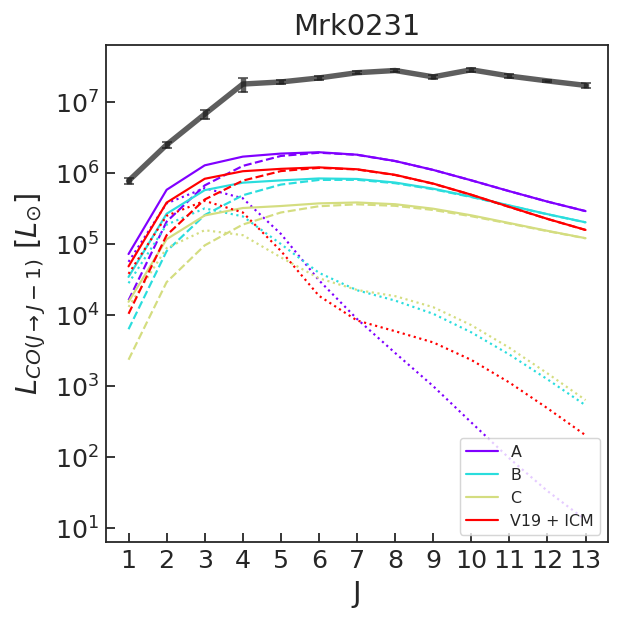

In [10]:
glist = [x for x in df['CO1'].dropna().index if x in frozenset(sers.index)]
colist, lo, hi, ulim = [['CO1tot' + suf] + ['CO' + str(x) + suf for x in np.arange(2,14)] 
                        for suf in ['', '_lo', '_up', '_ulim']]

for g in ['Mrk0231']:
    flu_conv = 1
    exbase = '/media/phd/jupyter/claudia/icm_sleds/' + g + '_icmSLED_'
    Mmol_tot, rCO, SFR, logLX = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR', 'logLX']]
    Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
    logLX_1_100 = logLX - np.log10(0.256)
    gSFR = logG0[np.abs(np.log10(SFR) - logG0).argmin()]
    fig, ax = plt.subplots(figsize=(5,5))
    for gmc, c in zip(gmclist, cm.rainbow(np.linspace(0, 1, len(gmclist)))):
        # add PDR of ICM
        Npdr = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=True)
        Nxdr = gmc.galaxy_xdr(logLX_1_100, rCO, Mmol_tot)
        try:
            pdr_icm = pd.read_csv(exbase + gmc.name + '_PDR.csv', index_col=0)
            pdr_gmc, xdr_gmc = gmc.pdr_xdr(icm=False)
            myXDR = (Nxdr.loc[xdr_gmc.index] * xdr_gmc.T).T.sum()
            myPDR = (Npdr.loc[pdr_gmc.index] * pdr_gmc.T).T.sum()
            myPDR = myPDR[:13] + pdr_icm.loc['g%03d' % (1e2*gSFR)]
            label = gmc.name + ' + ICM'
        except FileNotFoundError:
            pdr_gmc, xdr_gmc = gmc.pdr_xdr(icm=True)
            myXDR = (Nxdr.loc[xdr_gmc.index] * xdr_gmc.T).T.sum()
            myPDR = (Npdr.loc[pdr_gmc.index] * pdr_gmc.T).T.sum()
            label = gmc.name
        ax.plot(np.arange(1,14), myPDR[:13]/flu_conv, ls='dotted', color=c)
        ax.plot(np.arange(1,14), myXDR[:13]/flu_conv, ls='dashed', color=c)
        ax.plot(np.arange(1,14), (myPDR[:13] + myXDR[:13])/flu_conv, ls='solid', color=c, label=label)
    ax.errorbar(np.arange(1,14), df.loc[g, colist]/flu_conv, color='k', capsize=3, lw=3, alpha=.7,
                 yerr = [df.loc[g, lo]/flu_conv, df.loc[g, hi]/flu_conv], uplims = df.loc[g, ulim])
    ax.set_yscale('log')
    ax.set_xticks(np.arange(1,14))
    ax.legend(loc='lower right')
    #ax.set_ylim([1e-1, 1e3])
    ax.set_title(g)
    ax.set_xlabel('J')
    ax.set_ylabel(r'$L_{CO(J \rightarrow J-1)}$ $[L_{\odot}]$')
    fig.tight_layout();

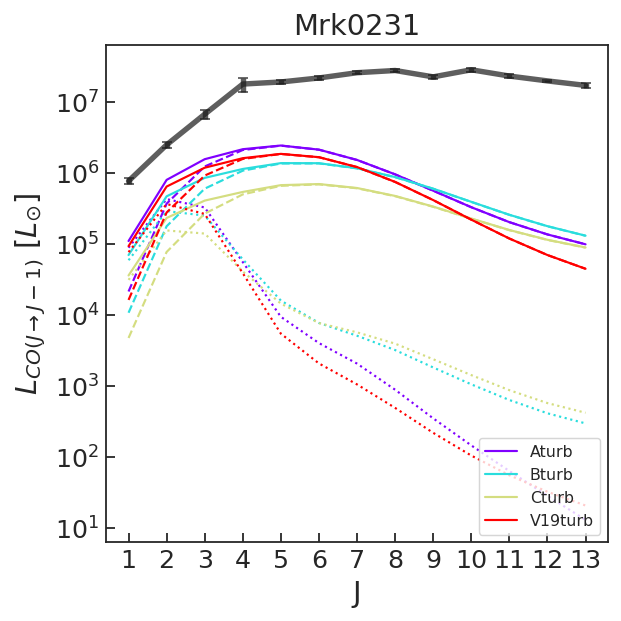

In [9]:
glist = [x for x in df['CO1'].dropna().index if x in frozenset(sers.index)]
colist, lo, hi, ulim = [['CO1tot' + suf] + ['CO' + str(x) + suf for x in np.arange(2,14)] 
                        for suf in ['', '_lo', '_up', '_ulim']]

for g in ['Mrk0231']:
    flu_conv = 1
    exbase = '/media/phd/jupyter/claudia/icm_sleds/' + g + '_icmSLED_'
    Mmol_tot, rCO, SFR, logLX = df.loc[g, ['Mmol_tot_XMW', 'rCO', 'SFR', 'logLX']]
    Ie, Re, n = sers.loc[g, ['I_e', 'R_e', 'n']]
    logLX_1_100 = logLX - np.log10(0.256)
    gSFR = logG0[np.abs(np.log10(SFR) - logG0).argmin()]
    fig, ax = plt.subplots(figsize=(5,5))
    for gmc, c in zip(gmcturb, cm.rainbow(np.linspace(0, 1, len(gmclist)))):
        # add PDR of ICM
        Npdr = gmc.galaxy_pdr(Ie, Re, n, rCO, Mmol_tot, SFR, G0floor=True)
        Nxdr = gmc.galaxy_xdr(logLX_1_100, rCO, Mmol_tot)
        try:
            pdr_icm = pd.read_csv(exbase + gmc.name + '_PDR.csv', index_col=0)
            pdr_gmc, xdr_gmc = gmc.pdr_xdr(icm=False)
            myXDR = (Nxdr.loc[xdr_gmc.index] * xdr_gmc.T).T.sum()
            myPDR = (Npdr.loc[pdr_gmc.index] * pdr_gmc.T).T.sum()
            myPDR = myPDR[:13] + pdr_icm.loc['g%03d' % (1e2*gSFR)]
            label = gmc.name + ' + ICM'
        except FileNotFoundError:
            pdr_gmc, xdr_gmc = gmc.pdr_xdr(icm=True)
            myXDR = (Nxdr.loc[xdr_gmc.index] * xdr_gmc.T).T.sum()
            myPDR = (Npdr.loc[pdr_gmc.index] * pdr_gmc.T).T.sum()
            label = gmc.name
        ax.plot(np.arange(1,14), myPDR[:13]/flu_conv, ls='dotted', color=c)
        ax.plot(np.arange(1,14), myXDR[:13]/flu_conv, ls='dashed', color=c)
        ax.plot(np.arange(1,14), (myPDR[:13] + myXDR[:13])/flu_conv, ls='solid', color=c, label=label)
    ax.errorbar(np.arange(1,14), df.loc[g, colist]/flu_conv, color='k', capsize=3, lw=3, alpha=.7,
                 yerr = [df.loc[g, lo]/flu_conv, df.loc[g, hi]/flu_conv], uplims = df.loc[g, ulim])
    ax.set_yscale('log')
    ax.set_xticks(np.arange(1,14))
    ax.legend(loc='lower right')
    #ax.set_ylim([1e-1, 1e3])
    ax.set_title(g)
    ax.set_xlabel('J')
    ax.set_ylabel(r'$L_{CO(J \rightarrow J-1)}$ $[L_{\odot}]$')
    fig.tight_layout();